We worked with two different preprocessed data sets in this notebook. "df_prep_numerical_only.pkl" is the preprocessed dataframe which combines all features that were used in all approaches together. In "df_prep_numerical_only_all_stats.pkl" all possible statistics were added for all features, i.e. maximum, minimum, mean, median, and variance. Mostly in the papers, just some of them were considered in their approaches. The latter data set was used for the experiments with all features combined, and for feature reduction methods. However, for the experiments with the single approaches it was easier to select the needed features with df_prep_numerical_only.pkl.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

# packages for models
import sklearn
from sklearn.svm import SVC
import skelm 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from xgboost import XGBClassifier
from hmmlearn import hmm

# dimensionality reduction
from sklearn.decomposition import PCA
from featurewiz import featurewiz

# import own functions
from ipynb.fs.full.Functions import load_train_test_data, model_eval, run_gridsearchCV, load_model, feature_importance

pd.set_option('display.max_columns', None)
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

Imported 0.2.8 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



# RBF-SVM with 1-1 
## Luengo et al. (2005). "Automatic Emotion Recognition using Prosodic Parameters" (Paper 4)
## Only 6 parameters

In [15]:
# load the data
df = pd.read_pickle('../results/df_prep_numerical_only.pkl')
df.columns

Index(['duration', 'mean', 'median', 'max', 'min', 'var', 'std',
       'speaking_rate', 'articulation_rate', 'asd',
       ...
       'lpc_local2_min', 'lpc_local3_mean', 'lpc_local3_var', 'lpc_local3_max',
       'lpc_local3_min', 'lpc_local4_mean', 'lpc_local4_var', 'lpc_local4_max',
       'lpc_local4_min', 'label'],
      dtype='object', length=270)

In [3]:
# selection of features (mean pitch, mean energy, pitch variance, skew of logarithmic pitch, range of logarithmic pitch,
# range of logarithmic energy)
df6param = df[['label','pitch_mean', 'pitch_var', 'energy_mean', 'skew_log_pitch', 'range_log_pitch', 'range_log_energy']].copy()
df6param.head()

label  pitch_mean  pitch_var  energy_mean  skew_log_pitch  range_log_pitch  \
0      4   -0.741135  -0.527264    -0.181987       -0.296694        -0.600449   
1      5   -1.386939  -1.070989     0.237872       -0.198081        -1.185553   
2      0   -0.448158  -0.159707     0.165869       -0.030373        -0.662848   
3      4    0.445340   0.432260     0.621608       -0.401886        -0.186604   
4      5   -1.177707  -1.082482     1.031302       -0.559679        -1.360023   

   range_log_energy  
0          0.125001  
1          0.125309  
2          0.131056  
3          0.114911  
4          0.112277

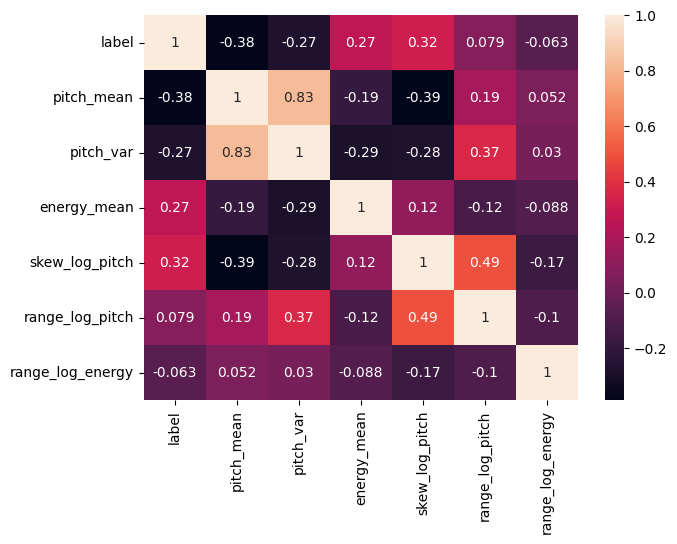

In [4]:
# look at the correlation of the data
plt.figure(figsize=(7,5))
sns.heatmap(df6param.corr(), annot=True)
plt.show()

We can see that *pitch_var* and *pitch_mean* show a highly positive correlation. *skew_log_pitch* and *range_log_pitch* are also positively correlated. 
Nevertheless, we also see that the features are not highly correlated with the target class which means they are not as useful for a model.

In [5]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df6param, test_size=0.2)

A snippet of the data:


pitch_mean  pitch_var  energy_mean  skew_log_pitch  range_log_pitch  \
476    1.879856   0.532507    -0.468976       -1.063461        -0.977611   
231   -0.785850  -0.792626     0.470740        0.251145         0.351752   
409   -0.222535   0.333957     0.392123        0.276181         1.645946   
69    -0.075026   0.036417    -0.483701        0.713622         1.730531   
68     0.336901   0.158635    -0.597045        0.067162         0.695059   

     range_log_energy  
476          0.070923  
231          0.124591  
409          0.128080  
69          -0.088574  
68           0.065724

There are 428 entries with 6 columns in the training data.
There are 107 entries with 6 columns in the testing data.


In [6]:
# compare statistics of these features per class
df6param.groupby('label').describe()

pitch_mean                                                              \
           count      mean       std       min       25%       50%       75%   
label                                                                          
0          127.0  0.689696  0.854154 -1.237117  0.098010  0.611862  1.220455   
1           81.0 -0.418604  0.613830 -1.466965 -1.004980 -0.254267  0.011152   
2           46.0 -0.171051  0.570315 -1.433670 -0.550613 -0.231479  0.301762   
3           69.0  0.156168  0.905825 -1.292712 -0.561537  0.012939  0.833352   
4           71.0  0.857590  0.959226 -1.001188  0.122822  0.840894  1.622096   
5           79.0 -0.617371  0.592247 -1.718260 -1.132451 -0.670270 -0.078147   
6           62.0 -1.108198  0.489678 -1.727773 -1.415668 -1.271766 -0.958159   

                pitch_var                                                    \
            max     count      mean       std       min       25%       50%   
label                                                                         
0      3.073941     127.0  0.715384  1.002463 -0.734068 -0.114924  0.563750   
1      0.731029      81.0 -0.701570  0.398769 -1.286442 -1.102002 -0.621115   
2      0.842627      46.0 -0.112042  0.537014 -1.076268 -0.401498 -0.062020   
3      2.127298      69.0  0.026308  0.794564 -1.132244 -0.623900  0.008392   
4      2.748186      71.0  0.846796  1.041707 -0.878306  0.027648  0.663345   
5      0.370440      79.0 -0.715391  0.422773 -1.284550 -1.109559 -0.750694   
6      0.539803      62.0 -0.553137  0.747083 -1.216611 -0.975058 -0.706568   

                          energy_mean                                          \
            75%       max       count      mean       std       min       25%   
label                                                                           
0      1.339874  3.232342       127.0 -0.529843  0.841799 -2.334219 -1.230734   
1     -0.408837  0.225256        81.0  0.012130  0.848196 -1.835554 -0.597045   
2      0.228115  1.705332        46.0 -0.142168  1.045840 -1.728615 -0.933925   
3      0.532507  2.007656        69.0  0.479938  0.956554 -1.681293 -0.286071   
4      1.777960  3.583298        71.0 -0.219051  0.904318 -1.920062 -0.953045   
5     -0.371378  0.366171        79.0  0.688053  0.953717 -1.088775  0.017811   
6     -0.453697  2.515015        62.0  0.014969  0.951420 -1.822611 -0.711565   

                                    skew_log_pitch                      \
            50%       75%       max          count      mean       std   
label                                                                    
0     -0.609235 -0.001773  1.882095          127.0 -0.539033  0.476105   
1     -0.005991  0.614168  1.947731           81.0  0.343137  0.690881   
2     -0.172431  0.518771  2.649275           46.0 -0.183320  0.892751   
3      0.418388  1.107696  2.930019           69.0 -0.011670  0.917714   
4     -0.130040  0.380397  1.794269           71.0 -0.445320  0.385847   
5      0.501303  1.312020  2.895989           79.0  0.082190  0.974325   
6     -0.020992  0.570391  2.699426           62.0  1.210093  1.500035   

                                                        range_log_pitch  \
            min       25%       50%       75%       max           count   
label                                                                     
0     -1.534939 -0.866976 -0.506416 -0.222557  0.861475           127.0   
1     -1.022515 -0.080791  0.212575  0.591289  2.979251            81.0   
2     -2.194094 -0.812821 -0.135425  0.342518  1.821081            46.0   
3     -1.388781 -0.530163 -0.192745  0.251145  3.182031            69.0   
4     -1.412852 -0.688763 -0.457764 -0.200277  0.276181            71.0   
5     -1.726307 -0.470560 -0.198081  0.234643  3.001234            79.0   
6     -1.085911  0.025810  0.825909  2.434594  4.915461            62.0   

                                                                             \
           mean       std       

In [7]:
svm_model = SVC(kernel='rbf', C=1, gamma=0.1, class_weight='balanced', decision_function_shape='ovo')
svm_model.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', decision_function_shape='ovo', gamma=0.1)


Evaluation: f1_score
52.52% for the train data
49.64% for the test data

Evaluation: accuracy_score
53.74% for the train data
52.34% for the test data

Evaluation: precision_score
56.06% for the train data
50.92% for the test data

Evaluation: recall_score
52.94% for the train data
51.31% for the test data

Evaluation: confusion_matrix of test predictions


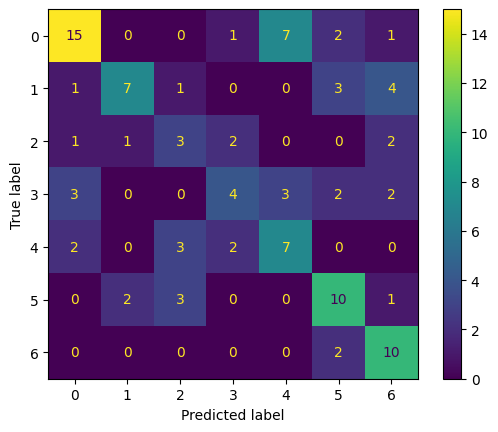


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['sadness(6)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)', 'sadness(6)']
Hard cases of false positives: ['happiness(4)', 'neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)', 'happiness(4)']
Hard cases of false positives: ['disgust(2)', 'happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['disgust(2)']
Hard cases of false positives: ['anger(0)']



In [8]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

A snippet of the data:


pitch_mean  energy_mean  range_log_pitch  range_log_energy
476    1.879856    -0.468976        -0.977611          0.070923
231   -0.785850     0.470740         0.351752          0.124591
409   -0.222535     0.392123         1.645946          0.128080
69    -0.075026    -0.483701         1.730531         -0.088574
68     0.336901    -0.597045         0.695059          0.065724

There are 428 entries with 4 columns in the training data.
There are 107 entries with 4 columns in the testing data.

Evaluation: f1_score
40.66% for the train data
35.00% for the test data

Evaluation: accuracy_score
42.52% for the train data
38.32% for the test data

Evaluation: precision_score
41.31% for the train data
35.63% for the test data

Evaluation: recall_score
41.45% for the train data
36.74% for the test data

Evaluation: confusion_matrix of test predictions


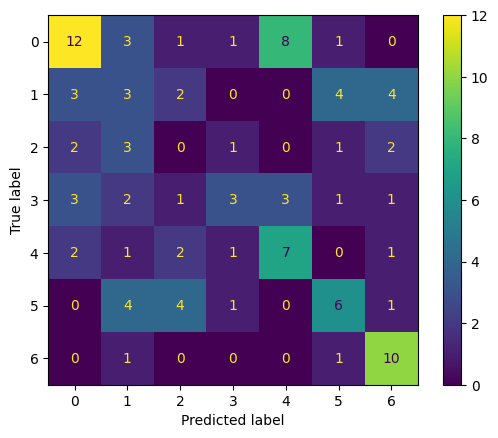


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)', 'sadness(6)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)', 'boredom(1)', 'sadness(6)']
Hard cases of false positives: ['neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)', 'happiness(4)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)', 'disgust(2)']
Hard cases of false positives: ['boredom(1)']

Label: sadness(6)
Hard cases of false positives: ['boredom(1)']



In [9]:
# drop correlated features and run again
df6param_uncor = df6param.drop(columns=['pitch_var', 'skew_log_pitch'])
# Load the train/test data
X_train_uncor, X_test_uncor, y_train_uncor, y_test_uncor = load_train_test_data(df6param_uncor, test_size=0.2)
svm_model.fit(X_train_uncor, y_train_uncor)
model_eval(svm_model, X_train_uncor, X_test_uncor, y_train_uncor, y_test_uncor, confusion=True)

Actually performs worse when dropping these features. 
Next, we try to run this very simple approach with a 70-30 train-test ratio.

### 70-30 ratio

A snippet of the data:


pitch_mean  pitch_var  energy_mean  skew_log_pitch  range_log_pitch  \
383    1.124506   0.790638     0.317044       -0.614154         0.777088   
180   -1.244695  -1.067021     1.236712        4.915461         1.674683   
447   -0.843777  -0.723884     0.816668        3.182031         1.773011   
409   -0.222535   0.333957     0.392123        0.276181         1.645946   
268    0.562568   0.790649     0.515033       -1.075998         0.105134   

     range_log_energy  
383          0.130748  
180         -0.053754  
447        -22.094930  
409          0.128080  
268          0.131261

There are 374 entries with 6 columns in the training data.
There are 161 entries with 6 columns in the testing data.

Evaluation: f1_score
53.07% for the train data
46.39% for the test data

Evaluation: accuracy_score
54.55% for the train data
48.45% for the test data

Evaluation: precision_score
55.70% for the train data
48.67% for the test data

Evaluation: recall_score
53.23% for the train data
47.59% for the test data

Evaluation: confusion_matrix of test predictions


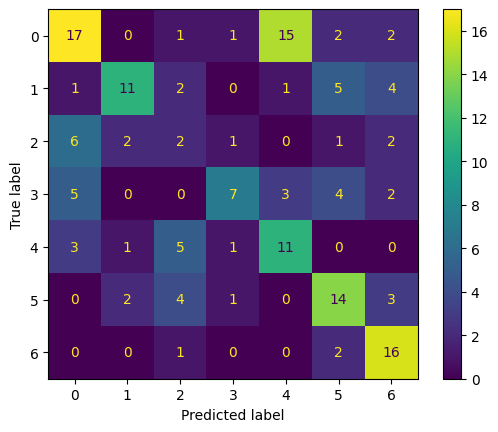


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['happiness(4)', 'neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['disgust(2)']
Hard cases of false positives: ['anger(0)']



In [10]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df6param, test_size=0.3)
svm_model.fit(X_train, y_train)
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

# SVM 
##  Shen et al. (2011) "Automatic Speech Emotion Recognition Using Support Vector Machine" (Paper 3)

In [13]:
# load the data
df = pd.read_pickle('../results/df_prep_numerical_only.pkl')
df.columns

Index(['duration', 'mean', 'median', 'max', 'min', 'var', 'std',
       'speaking_rate', 'articulation_rate', 'asd',
       ...
       'lpc_local2_min', 'lpc_local3_mean', 'lpc_local3_var', 'lpc_local3_max',
       'lpc_local3_min', 'lpc_local4_mean', 'lpc_local4_var', 'lpc_local4_max',
       'lpc_local4_min', 'label'],
      dtype='object', length=270)

In [14]:
# selection of features: 
# energy features (19-dim), pitch features (19-dim), LPCCs (48-dim), MFCCs (52-dim), LPCMFCCs (48-dim) 
# -> 186 features + label
df_3 = df.filter(regex='energy_|pitch_|lpccs_|^mfccs|lpcmfccs_|label')
df_3.columns

Index(['energy_max', 'energy_mean', 'energy_var', 'energy_rising_duration_max',
       'energy_rising_duration_mean', 'energy_rising_duration_median',
       'energy_rising_duration_iqr', 'energy_falling_duration_max',
       'energy_falling_duration_mean', 'energy_falling_duration_median',
       ...
       'lpcmfccs_local9_min', 'lpcmfccs_local10_mean', 'lpcmfccs_local10_var',
       'lpcmfccs_local10_max', 'lpcmfccs_local10_min', 'lpcmfccs_local11_mean',
       'lpcmfccs_local11_var', 'lpcmfccs_local11_max', 'lpcmfccs_local11_min',
       'label'],
      dtype='object', length=187)

In [13]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3, test_size=0.3)

A snippet of the data:


energy_max  energy_mean  energy_var  energy_rising_duration_max  \
383    0.109759     0.317044   -0.519381                    0.154575   
180    0.109759     1.236712   -0.266154                   -0.317983   
447   -0.957895     0.816668   -0.775869                   -0.317983   
409   -0.957895     0.392123    0.144504                   -0.790542   
268    0.109759     0.515033    1.146886                    1.572250   

     energy_rising_duration_mean  energy_rising_duration_median  \
383                    -0.085189                      -0.403414   
180                     0.624888                       0.812510   
447                     0.471038                       0.812510   
409                     0.932588                       0.812510   
268                     0.496680                      -0.403414   

     energy_rising_duration_iqr  energy_falling_duration_max  \
383                   -0.297992                     0.495361   
180                    0.245196                     0.138674   
447                   -0.569585                     0.138674   
409                    0.788383                     0.852048   
268                   -0.026398                    -0.931386   

     energy_falling_duration_mean  energy_falling_duration_median  \
383                     -0.590703                       -0.654226   
180                     -0.257298                       -0.654226   
447                      0.380095                        0.609351   
409                      2.292274                        1.872928   
268                     -0.852198                       -0.022437   

     energy_falling_duration_iqr  energy_rising_value_max  \
383                    -0.547918                 0.881426   
180                    -0.547918                -1.528019   
447                    -0.061788                -0.482673   
409                     0.424341                 0.881361   
268                    -0.061788                 0.489421   

     energy_rising_value_mean  energy_rising_value_median  \
383                  0.303215                    0.088429   
180                  0.558722                    0.386039   
447                  0.367301                    0.757903   
409                  2.488701                    2.236804   
268                  0.802233                    0.629266   

     energy_rising_value_iqr  energy_falling_value_max  \
383                 0.079898                 -0.214919   
180                 0.773297                  0.470809   
447                 0.334623                  0.011360   
409                -1.633813                 -2.422688   
268                 0.911353                  0.442065   

     energy_falling_value_mean  energy_falling_value_median  \
383                  -0.301878                     0.224093   
180                  -0.557024                    -1.013233   
447                  -0.293724                    -0.423480   
409                  -2.488577                    -2.421592   
268                  -0.801180                    -0.050827   

     energy_falling_value_iqr  pitch_max  pitch_mean  pitch_var  \
383                 -0.101900   0.711926    1.124506   0.790638   
180                  0.249905   1.286278   -1.244695  -1.067021   
447                 -0.047329   1.482661   -0.843777  -0.723884   
409                 -1.276918   1.386620   -0.222535   0.333957   
268                  1.671711  -0.105880    0.562568   0.790649   

     pitch_rising_duration_max  pitch_rising_duration_mean  \
383                  -0.431252                    0.379931   
180                  -0.348035                   -1.897403   
447                  -0.472861                   -0.379591   
409                  -0.472861                    0.541053   
268                  -0.389644                    0.569128   

     pitch_rising_duration_median  pitch_rising_duration_iqr  \
383                      0.467001                   0.714805   
180

There are 374 entries with 186 columns in the training data.
There are 161 entries with 186 columns in the testing data.


In [14]:
svm_model = SVC(kernel='rbf', C=1, gamma=0.1, class_weight='balanced', decision_function_shape='ovo')
svm_model.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', decision_function_shape='ovo', gamma=0.1)


Evaluation: f1_score
100.00% for the train data
3.71% for the test data

Evaluation: accuracy_score
100.00% for the train data
14.91% for the test data

Evaluation: precision_score
100.00% for the train data
2.13% for the test data

Evaluation: recall_score
100.00% for the train data
14.29% for the test data

Evaluation: confusion_matrix of test predictions


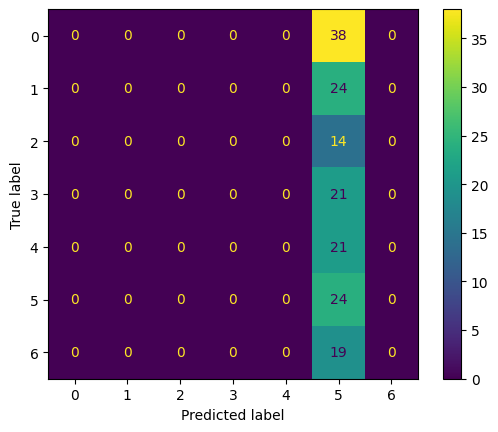


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['neutral(5)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['neutral(5)']

Label: neutral(5)
Hard cases of false positives: ['anger(0)']

Label: sadness(6)
Hard cases of false negatives: ['neutral(5)']



In [15]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

In [16]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()


Evaluation: f1_score
93.41% for the train data
75.96% for the test data

Evaluation: accuracy_score
93.32% for the train data
77.02% for the test data

Evaluation: precision_score
94.58% for the train data
79.85% for the test data

Evaluation: recall_score
92.69% for the train data
74.53% for the test data

Evaluation: confusion_matrix of test predictions


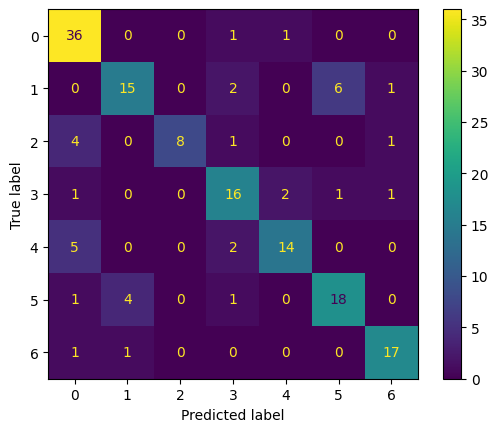


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [17]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

This is actually a really good result! We achieve 93.41% F1 macro on train set and 75.96% on the test set.

### Try with 90-10 train-test split as in paper

In [18]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3, test_size=0.1)

A snippet of the data:


energy_max  energy_mean  energy_var  energy_rising_duration_max  \
237    0.109759     0.171386    0.237628                    0.627134   
459   -0.957895     0.300091   -0.525615                   -0.790542   
142   -0.957895     1.185660    0.922756                   -0.317983   
148    0.109759     0.104880   -1.020438                    1.099692   
124   -0.957895    -1.492359   -1.505395                   -0.790542   

     energy_rising_duration_mean  energy_rising_duration_median  \
237                    -0.605913                      -1.619339   
459                    -0.605913                      -0.403414   
142                    -0.315307                       0.812510   
148                     0.844674                      -0.403414   
124                    -0.034469                       0.812510   

     energy_rising_duration_iqr  energy_falling_duration_max  \
237                    0.245196                     0.852048   
459                   -0.569585                    -0.218012   
142                   -0.297992                    -0.574699   
148                   -0.297992                     1.922108   
124                   -1.384366                     0.138674   

     energy_falling_duration_mean  energy_falling_duration_median  \
237                      0.507574                       -0.022437   
459                     -1.149648                       -1.917803   
142                     -0.427269                       -0.022437   
148                      2.183007                        0.609351   
124                     -0.639733                       -0.654226   

     energy_falling_duration_iqr  energy_rising_value_max  \
237                     0.910471                 0.881426   
459                    -0.790983                 0.068078   
142                     0.424341                 0.866587   
148                     1.882731                 0.879941   
124                    -0.790983                 0.199761   

     energy_rising_value_mean  energy_rising_value_median  \
237                 -0.588191                   -0.388733   
459                 -0.331955                   -0.365984   
142                 -0.296133                   -0.533474   
148                  0.363359                    0.391187   
124                 -1.118418                   -0.760071   

     energy_rising_value_iqr  energy_falling_value_max  \
237                -0.270175                  0.485800   
459                -0.207326                 -0.057802   
142                 0.224939                  0.484144   
148                -0.098750                 -0.263682   
124                -1.285209                  0.471333   

     energy_falling_value_mean  energy_falling_value_median  \
237                   0.589991                    -0.276818   
459                   0.330099                     0.000011   
142                   0.297289                     0.532156   
148                  -0.362348                     0.432517   
124                   1.120076                     0.822558   

     energy_falling_value_iqr  pitch_max  pitch_mean  pitch_var  \
237                 -0.853516  -1.368069   -1.127652  -1.065341   
459                 -1.441553   1.520861    0.632071  -0.266562   
142                  0.162293   0.694023   -0.719666  -0.701676   
148                  0.252095  -1.228418   -0.081268  -0.829449   
124                 -1.088912   0.718609    1.331808   2.032421   

     pitch_rising_duration_max  pitch_rising_duration_mean  \
237                   0.608964                    0.877945   
459                  -0.847339                   -1.782098   
142                  -0.348035                   -0.965603   
148                  -0.722513                   -1.150425   
124                  -0.348035                    0.054431   

     pitch_rising_duration_median  pitch_rising_duration_iqr  \
237                      0.805774                  -0.233541   
459

There are 481 entries with 186 columns in the training data.
There are 54 entries with 186 columns in the testing data.


In [19]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()


Evaluation: f1_score
93.33% for the train data
72.99% for the test data

Evaluation: accuracy_score
93.35% for the train data
74.07% for the test data

Evaluation: precision_score
94.40% for the train data
76.13% for the test data

Evaluation: recall_score
92.60% for the train data
72.23% for the test data

Evaluation: confusion_matrix of test predictions


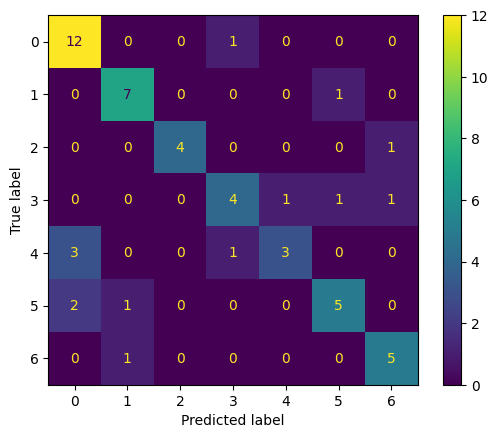


Hard cases for the model:

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['anger(0)']



In [20]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

The model is actually a bit better with a 70-30 train-test split. Just the hard cases change slightly.

### Try with 5 emotions only as in paper

In [5]:
# load the data
df_5emos = pd.read_pickle('../results/df_prep_5emos_numerical_only.pkl')

# selection of features
df_5emos = df_5emos.filter(regex='energy_|pitch_|lpccs_|^mfccs|lpcmfccs_|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_5emos, test_size=0.3)

A snippet of the data:


energy_max  energy_mean  energy_var  energy_rising_duration_max  \
284    0.173813     0.052093   -0.196113                   -0.859346   
20     0.173813    -0.838548   -0.836588                    1.038493   
246    0.173813    -1.237702   -0.577087                    0.564033   
337    2.440066    -0.202697   -0.118620                    0.089574   
147   -0.959314    -0.441459   -0.232705                    1.512952   

     energy_rising_duration_mean  energy_rising_duration_median  \
284                     0.334942                       0.851736   
20                     -0.108332                      -0.346349   
246                     1.369250                       0.851736   
337                     0.630459                       0.851736   
147                    -0.108332                      -0.346349   

     energy_rising_duration_iqr  energy_falling_duration_max  \
284                   -0.653194                    -0.619062   
20                    -0.653194                     0.052496   
246                    2.324508                     1.059834   
337                    0.158907                     1.059834   
147                   -0.382494                     0.052496   

     energy_falling_duration_mean  energy_falling_duration_median  \
284                     -0.348594                       -0.091304   
20                       0.162963                        0.527738   
246                      1.044959                        0.527738   
337                      1.236059                        0.527738   
147                      0.309963                        1.146780   

     energy_falling_duration_iqr  energy_rising_value_max  \
284                     0.301873                 0.734519   
20                     -0.863674                 0.888698   
246                     2.399857                -0.494328   
337                    -0.630564                 0.589837   
147                     0.534983                -1.506083   

     energy_rising_value_mean  energy_rising_value_median  \
284                  0.368781                    0.398451   
20                  -0.529549                   -0.843670   
246                 -0.834105                   -0.855576   
337                  0.776432                    1.472091   
147                 -0.052799                    0.149975   

     energy_rising_value_iqr  energy_falling_value_max  \
284                 0.285941                  0.450498   
20                  0.354686                  0.465357   
246                -0.525021                  0.489229   
337                 1.653687                  0.487926   
147                 0.770346                  0.483786   

     energy_falling_value_mean  energy_falling_value_median  \
284                  -0.365881                    -0.605702   
20                    0.532951                     0.558804   
246                   0.837562                     0.935570   
337                  -0.773792                    -1.030215   
147                   0.055948                     0.784281   

     energy_falling_value_iqr  pitch_max  pitch_mean  pitch_var  \
284                  1.937908  -1.490889   -1.294450  -1.084715   
20                  -0.119684  -1.398648   -1.258015  -0.993216   
246                 -0.633375   0.985515   -0.204302   0.329960   
337                  1.025917  -0.663392    0.067489  -0.021969   
147                  1.030643  -0.990571   -0.439648  -0.603176   

     pitch_rising_duration_max  pitch_rising_duration_mean  \
284                  -0.382507                    0.337987   
20                   -0.243002                   -0.705830   
246                   0.628903                    2.497482   
337                   0.977666                   -0.448984   
147                   0.105760                    1.181861   

     pitch_rising_duration_median  pitch_rising_duration_iqr  \
284                      0.161692                   1.409657   
20 

There are 237 entries with 186 columns in the training data.
There are 102 entries with 186 columns in the testing data.


In [22]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()


Evaluation: f1_score
97.40% for the train data
78.68% for the test data

Evaluation: accuracy_score
97.05% for the train data
77.45% for the test data

Evaluation: precision_score
97.41% for the train data
80.13% for the test data

Evaluation: recall_score
97.39% for the train data
77.79% for the test data

Evaluation: confusion_matrix of test predictions


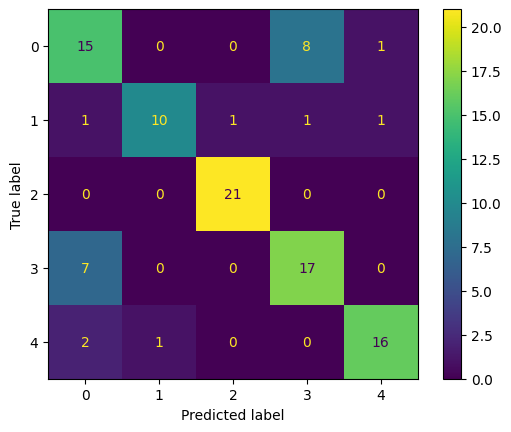


Hard cases for the model:

Label: boredom(0)
Hard cases of false negatives: ['neutral(3)']
Hard cases of false positives: ['neutral(3)']

Label: neutral(3)
Hard cases of false negatives: ['boredom(0)']
Hard cases of false positives: ['boredom(0)']



In [23]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True, emotions='5emos')

Do the same with the 90-10 train-test split.

In [24]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_5emos, test_size=0.1)

A snippet of the data:


energy_max  energy_mean  energy_var  energy_rising_duration_max  \
102    2.440066     0.809484    0.662290                    1.038493   
53    -0.959314     0.613678   -0.366092                    0.564033   
303    2.440066     1.530193    0.500537                   -0.859346   
24    -0.959314    -1.651078   -1.749471                    0.564033   
225    0.173813    -1.068863   -0.337114                   -1.333805   

     energy_rising_duration_mean  energy_rising_duration_median  \
102                     1.221491                      -0.346349   
53                     -0.673290                      -1.544435   
303                     0.384195                       0.252694   
24                     -1.466754                      -1.544435   
225                    -0.748617                      -0.346349   

     energy_rising_duration_iqr  energy_falling_duration_max  \
102                   -1.465294                     0.052496   
53                     0.700307                     0.388276   
303                    0.158907                     1.059834   
24                    -0.382494                     0.724055   
225                   -1.465294                    -1.290620   

     energy_falling_duration_mean  energy_falling_duration_median  \
102                      1.627077                        0.527738   
53                      -1.045890                       -1.948430   
303                      1.956355                        1.765822   
24                      -1.655087                       -1.948430   
225                     -0.842512                        0.527738   

     energy_falling_duration_iqr  energy_rising_value_max  \
102                     2.166748                -2.895442   
53                     -0.630564                 0.454624   
303                     0.068764                -1.843766   
24                      0.301873                -2.509079   
225                    -0.164346                 0.679837   

     energy_rising_value_mean  energy_rising_value_median  \
102                  1.765040                    2.800741   
53                  -0.492981                   -0.813219   
303                  1.166350                    1.489401   
24                  -2.086333                   -1.273116   
225                 -0.812124                   -0.937613   

     energy_rising_value_iqr  energy_falling_value_max  \
102                -1.188706                 -1.633324   
53                 -0.446101                  0.355930   
303                 0.601045                 -2.440634   
24                 -1.586567                  0.489945   
225                -1.359014                  0.479213   

     energy_falling_value_mean  energy_falling_value_median  \
102                  -1.762179                    -1.196550   
53                    0.496156                     0.703646   
303                  -1.163639                    -1.380638   
24                    2.090393                     1.389933   
225                   0.815615                     0.868317   

     energy_falling_value_iqr  pitch_max  pitch_mean  pitch_var  \
102                  0.681198  -1.270991   -0.831984  -0.950074   
53                   0.019765  -0.402278    0.233950  -0.138841   
303                 -0.370068  -0.744733    0.377282  -0.253398   
24                  -1.190704  -1.362564   -1.414373  -1.020526   
225                 -1.004735   0.036032    1.028028   1.083461   

     pitch_rising_duration_max  pitch_rising_duration_mean  \
102                  -0.731269                   -0.511768   
53                    0.419646                    0.086031   
303                  -0.661516                   -0.620715   
24                    3.907267                    0.273720   
225                  -0.452259                    0.485493   

     pitch_rising_duration_median  pitch_rising_duration_iqr  \
102                     -0.258336                   0.667873   
53 

There are 305 entries with 186 columns in the training data.
There are 34 entries with 186 columns in the testing data.


In [25]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()


Evaluation: f1_score
96.69% for the train data
89.33% for the test data

Evaluation: accuracy_score
96.39% for the train data
88.24% for the test data

Evaluation: precision_score
96.93% for the train data
91.14% for the test data

Evaluation: recall_score
96.51% for the train data
88.50% for the test data

Evaluation: confusion_matrix of test predictions


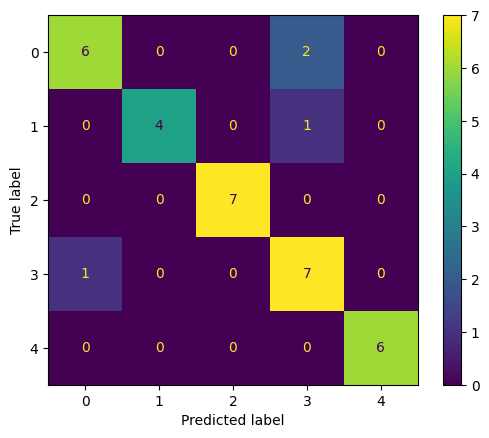


Hard cases for the model:

Label: boredom(0)
Hard cases of false negatives: ['neutral(3)']



In [26]:
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True, emotions='5emos')

Finally, we see that the model is even better with 5 emotions only. In this case, a 90-10 train-test split even improves the performance. Only with *boredom* and *neutral* it has a hard time.

### Test the model performance with a selection of features as in paper 3
### 1) Only energy and pitch

A snippet of the data:


energy_max  energy_mean  energy_var  energy_rising_duration_max  \
237    0.109759     0.171386    0.237628                    0.627134   
459   -0.957895     0.300091   -0.525615                   -0.790542   
142   -0.957895     1.185660    0.922756                   -0.317983   
148    0.109759     0.104880   -1.020438                    1.099692   
124   -0.957895    -1.492359   -1.505395                   -0.790542   

     energy_rising_duration_mean  energy_rising_duration_median  \
237                    -0.605913                      -1.619339   
459                    -0.605913                      -0.403414   
142                    -0.315307                       0.812510   
148                     0.844674                      -0.403414   
124                    -0.034469                       0.812510   

     energy_rising_duration_iqr  energy_falling_duration_max  \
237                    0.245196                     0.852048   
459                   -0.569585                    -0.218012   
142                   -0.297992                    -0.574699   
148                   -0.297992                     1.922108   
124                   -1.384366                     0.138674   

     energy_falling_duration_mean  energy_falling_duration_median  \
237                      0.507574                       -0.022437   
459                     -1.149648                       -1.917803   
142                     -0.427269                       -0.022437   
148                      2.183007                        0.609351   
124                     -0.639733                       -0.654226   

     energy_falling_duration_iqr  energy_rising_value_max  \
237                     0.910471                 0.881426   
459                    -0.790983                 0.068078   
142                     0.424341                 0.866587   
148                     1.882731                 0.879941   
124                    -0.790983                 0.199761   

     energy_rising_value_mean  energy_rising_value_median  \
237                 -0.588191                   -0.388733   
459                 -0.331955                   -0.365984   
142                 -0.296133                   -0.533474   
148                  0.363359                    0.391187   
124                 -1.118418                   -0.760071   

     energy_rising_value_iqr  energy_falling_value_max  \
237                -0.270175                  0.485800   
459                -0.207326                 -0.057802   
142                 0.224939                  0.484144   
148                -0.098750                 -0.263682   
124                -1.285209                  0.471333   

     energy_falling_value_mean  energy_falling_value_median  \
237                   0.589991                    -0.276818   
459                   0.330099                     0.000011   
142                   0.297289                     0.532156   
148                  -0.362348                     0.432517   
124                   1.120076                     0.822558   

     energy_falling_value_iqr  pitch_max  pitch_mean  pitch_var  \
237                 -0.853516  -1.368069   -1.127652  -1.065341   
459                 -1.441553   1.520861    0.632071  -0.266562   
142                  0.162293   0.694023   -0.719666  -0.701676   
148                  0.252095  -1.228418   -0.081268  -0.829449   
124                 -1.088912   0.718609    1.331808   2.032421   

     pitch_rising_duration_max  pitch_rising_duration_mean  \
237                   0.608964                    0.877945   
459                  -0.847339                   -1.782098   
142                  -0.348035                   -0.965603   
148                  -0.722513                   -1.150425   
124                  -0.348035                    0.054431   

     pitch_rising_duration_median  pitch_rising_duration_iqr  \
237                      0.805774                  -0.233541   
459

There are 481 entries with 38 columns in the training data.
There are 54 entries with 38 columns in the testing data.

Evaluation: f1_score
82.36% for the train data
54.15% for the test data

Evaluation: accuracy_score
83.37% for the train data
59.26% for the test data

Evaluation: precision_score
84.58% for the train data
62.74% for the test data

Evaluation: recall_score
81.19% for the train data
54.19% for the test data

Evaluation: confusion_matrix of test predictions


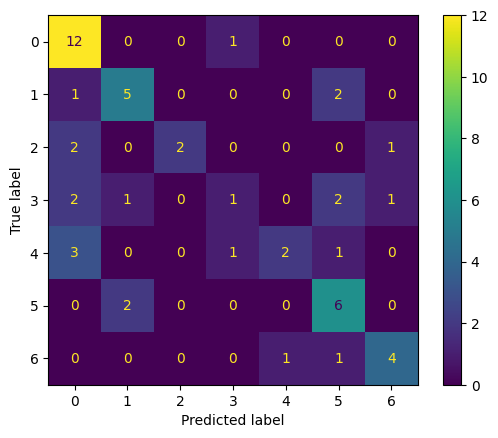


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)', 'neutral(5)']
Hard cases of false positives: ['anger(0)', 'happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['sadness(6)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [6]:
# select the features
df_3_ep = df_3.filter(regex='energy_|pitch_|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_ep, test_size=0.1)

# train the model
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

#### With 5 emos only

A snippet of the data:


energy_max  energy_mean  energy_var  energy_rising_duration_max  \
102    2.440066     0.809484    0.662290                    1.038493   
53    -0.959314     0.613678   -0.366092                    0.564033   
303    2.440066     1.530193    0.500537                   -0.859346   
24    -0.959314    -1.651078   -1.749471                    0.564033   
225    0.173813    -1.068863   -0.337114                   -1.333805   

     energy_rising_duration_mean  energy_rising_duration_median  \
102                     1.221491                      -0.346349   
53                     -0.673290                      -1.544435   
303                     0.384195                       0.252694   
24                     -1.466754                      -1.544435   
225                    -0.748617                      -0.346349   

     energy_rising_duration_iqr  energy_falling_duration_max  \
102                   -1.465294                     0.052496   
53                     0.700307                     0.388276   
303                    0.158907                     1.059834   
24                    -0.382494                     0.724055   
225                   -1.465294                    -1.290620   

     energy_falling_duration_mean  energy_falling_duration_median  \
102                      1.627077                        0.527738   
53                      -1.045890                       -1.948430   
303                      1.956355                        1.765822   
24                      -1.655087                       -1.948430   
225                     -0.842512                        0.527738   

     energy_falling_duration_iqr  energy_rising_value_max  \
102                     2.166748                -2.895442   
53                     -0.630564                 0.454624   
303                     0.068764                -1.843766   
24                      0.301873                -2.509079   
225                    -0.164346                 0.679837   

     energy_rising_value_mean  energy_rising_value_median  \
102                  1.765040                    2.800741   
53                  -0.492981                   -0.813219   
303                  1.166350                    1.489401   
24                  -2.086333                   -1.273116   
225                 -0.812124                   -0.937613   

     energy_rising_value_iqr  energy_falling_value_max  \
102                -1.188706                 -1.633324   
53                 -0.446101                  0.355930   
303                 0.601045                 -2.440634   
24                 -1.586567                  0.489945   
225                -1.359014                  0.479213   

     energy_falling_value_mean  energy_falling_value_median  \
102                  -1.762179                    -1.196550   
53                    0.496156                     0.703646   
303                  -1.163639                    -1.380638   
24                    2.090393                     1.389933   
225                   0.815615                     0.868317   

     energy_falling_value_iqr  pitch_max  pitch_mean  pitch_var  \
102                  0.681198  -1.270991   -0.831984  -0.950074   
53                   0.019765  -0.402278    0.233950  -0.138841   
303                 -0.370068  -0.744733    0.377282  -0.253398   
24                  -1.190704  -1.362564   -1.414373  -1.020526   
225                 -1.004735   0.036032    1.028028   1.083461   

     pitch_rising_duration_max  pitch_rising_duration_mean  \
102                  -0.731269                   -0.511768   
53                    0.419646                    0.086031   
303                  -0.661516                   -0.620715   
24                    3.907267                    0.273720   
225                  -0.452259                    0.485493   

     pitch_rising_duration_median  pitch_rising_duration_iqr  \
102                     -0.258336                   0.667873   
53 

There are 305 entries with 38 columns in the training data.
There are 34 entries with 38 columns in the testing data.

Evaluation: f1_score
87.14% for the train data
66.28% for the test data

Evaluation: accuracy_score
86.89% for the train data
73.53% for the test data

Evaluation: precision_score
87.70% for the train data
66.55% for the test data

Evaluation: recall_score
86.78% for the train data
68.81% for the test data

Evaluation: confusion_matrix of test predictions


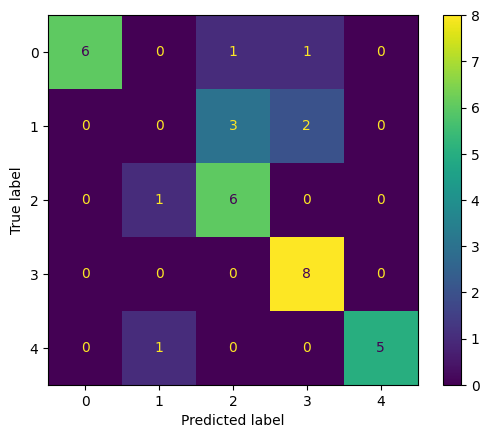


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['disgust(2)', 'fear(3)']
Hard cases of false positives: ['disgust(2)', 'happiness(4)']

Label: disgust(2)
Hard cases of false positives: ['boredom(1)']



In [7]:
# select the features
df_5emos_3_ep = df_5emos.filter(regex='energy_|pitch_|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_5emos_3_ep, test_size=0.1)

# train the model
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

We get 73.53% test accuracy compared to 66.02% recognition rate with 5 emotions and 90-10 train-test split in paper 3.
### 2) Only LPCMFCC


Evaluation: f1_score
40.61% for the train data
30.67% for the test data

Evaluation: accuracy_score
50.31% for the train data
44.44% for the test data

Evaluation: precision_score
47.94% for the train data
27.73% for the test data

Evaluation: recall_score
44.09% for the train data
37.51% for the test data

Evaluation: confusion_matrix of test predictions


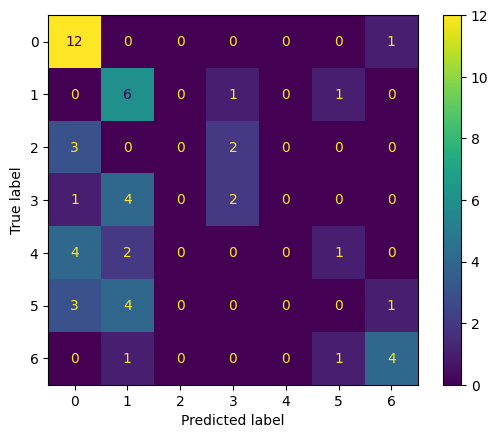


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['fear(3)', 'neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)', 'fear(3)']

Label: fear(3)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['disgust(2)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)', 'boredom(1)']

Label: neutral(5)
Hard cases of false negatives: ['anger(0)', 'boredom(1)']
Hard cases of false positives: ['boredom(1)', 'happiness(4)', 'sadness(6)']



In [36]:
# select the features
df_3_lpcmfcc = df_3.filter(regex='lpcmfccs_|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_lpcmfcc, verbose=False, test_size=0.1)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
56.33% for the train data
47.12% for the test data

Evaluation: accuracy_score
56.96% for the train data
48.15% for the test data

Evaluation: precision_score
57.42% for the train data
48.55% for the test data

Evaluation: recall_score
57.21% for the train data
47.68% for the test data

Evaluation: confusion_matrix of test predictions


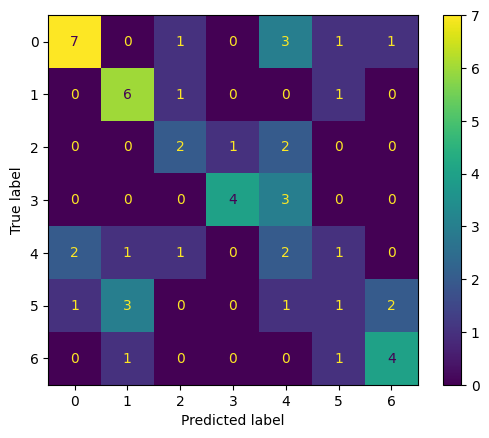


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['happiness(4)']

Label: fear(3)
Hard cases of false negatives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)', 'fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)', 'sadness(6)']

Label: sadness(6)
Hard cases of false positives: ['neutral(5)']



In [37]:
# change the model's hyperparameter
# train the model
svm_model = SVC(C=1, gamma=0.1, class_weight='balanced', decision_function_shape='ovo')
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

Especially balancing but also the other hyperparamaters can improve the model. Nevertheless, we are not as good as in paper 3. 
<br>  How about when we only use 5 emotions?
#### 5 emos only


Evaluation: f1_score
62.34% for the train data
54.97% for the test data

Evaluation: accuracy_score
61.97% for the train data
52.94% for the test data

Evaluation: precision_score
63.42% for the train data
57.90% for the test data

Evaluation: recall_score
63.75% for the train data
56.71% for the test data

Evaluation: confusion_matrix of test predictions


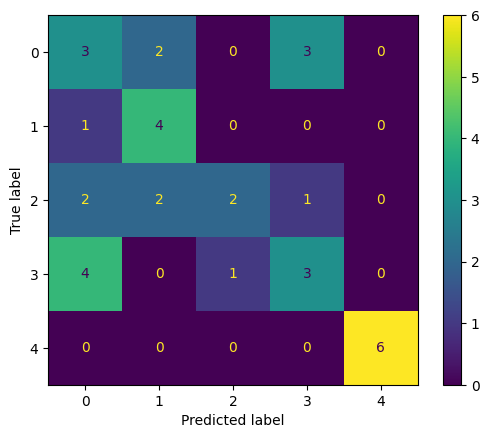


Hard cases for the model:

Label: boredom(0)
Hard cases of false negatives: ['disgust(1)', 'neutral(3)']
Hard cases of false positives: ['neutral(3)']

Label: disgust(1)
Hard cases of false positives: ['boredom(0)', 'happiness(2)']

Label: happiness(2)
Hard cases of false negatives: ['boredom(0)', 'disgust(1)']
Hard cases of false positives: ['neutral(3)']

Label: neutral(3)
Hard cases of false negatives: ['boredom(0)']
Hard cases of false positives: ['boredom(0)']



In [31]:
# load the train/test data
df_5emos_lpcmfccs = df_5emos.filter(regex='lpcmfccs_|label')
X_train, X_test, y_train, y_test = load_train_test_data(df_5emos_lpcmfccs, test_size=0.1, verbose=False)

# train the model
svm_model = SVC(C=1, gamma=0.1, class_weight='balanced', decision_function_shape='ovo')
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True, emotions='5emos')

The LPCMFCC features alone don't seem to be very good or at least not sufficient enough. The model has a hard time at predicting emotions other than *anger* and *boredom*. We get 52.94% test accuracy compared to 70.7% recognition rate with 5 emotions and 90-10 train-test split in paper 3.

### 3) energy, pitch, LPCC, MFCC


Evaluation: f1_score
95.29% for the train data
74.27% for the test data

Evaluation: accuracy_score
95.22% for the train data
75.93% for the test data

Evaluation: precision_score
96.08% for the train data
78.27% for the test data

Evaluation: recall_score
94.69% for the train data
73.33% for the test data

Evaluation: confusion_matrix of test predictions


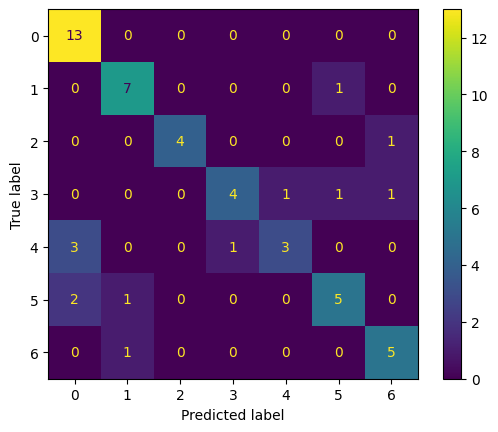


Hard cases for the model:

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['anger(0)']



In [32]:
# select the features
df_3_eplm = df_3.filter(regex='energy_|pitch_|lpccs_|^mfccs|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_eplm, verbose=False, test_size=0.1)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
95.28% for the train data
76.79% for the test data

Evaluation: accuracy_score
95.19% for the train data
77.64% for the test data

Evaluation: precision_score
96.15% for the train data
79.28% for the test data

Evaluation: recall_score
94.69% for the train data
75.67% for the test data

Evaluation: confusion_matrix of test predictions


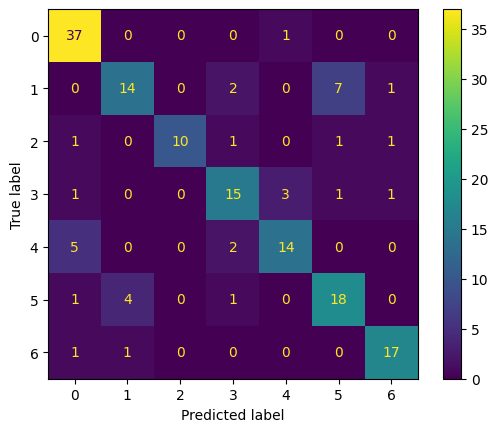


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [33]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_eplm, verbose=False, test_size=0.3)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

We get a slightly better generalization with a 70-30 split.

#### 90-10 split with 5 emos only


Evaluation: f1_score
98.05% for the train data
91.76% for the test data

Evaluation: accuracy_score
97.70% for the train data
91.18% for the test data

Evaluation: precision_score
98.06% for the train data
94.55% for the test data

Evaluation: recall_score
98.05% for the train data
91.00% for the test data

Evaluation: confusion_matrix of test predictions


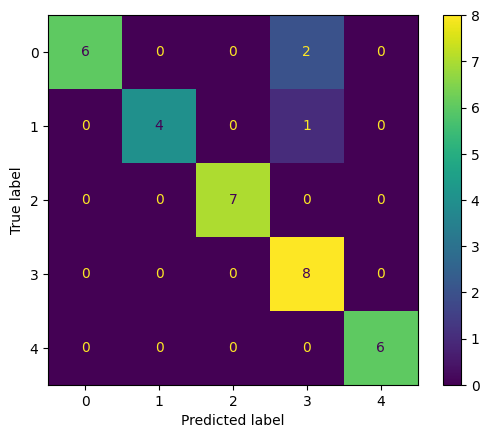


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['fear(3)']



In [8]:
# select the features
df_5emos_3_eplm = df_5emos.filter(regex='energy_|pitch_|lpccs_|^mfccs|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_5emos_3_eplm, verbose=False, test_size=0.1)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

These are very good results with a 90-10 split and 5 emotions only as in the paper! We get 91.18% test accuracy compared to 78.17% recognition rate in the paper.

### 4) energy, pitch, LPCMFCC


Evaluation: f1_score
76.89% for the train data
56.58% for the test data

Evaluation: accuracy_score
77.96% for the train data
61.11% for the test data

Evaluation: precision_score
80.36% for the train data
63.78% for the test data

Evaluation: recall_score
75.56% for the train data
55.20% for the test data

Evaluation: confusion_matrix of test predictions


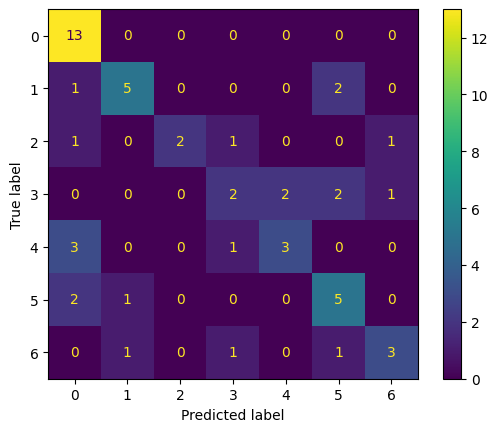


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['happiness(4)', 'neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['anger(0)']



In [38]:
# select the features
df_3_eplpcmfcc = df_3.filter(regex='energy_|pitch_|lpcmfccs_|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_eplpcmfcc, verbose=False, test_size=0.1)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

#### 5 emos only


Evaluation: f1_score
86.38% for the train data
82.91% for the test data

Evaluation: accuracy_score
86.23% for the train data
85.29% for the test data

Evaluation: precision_score
87.06% for the train data
90.10% for the test data

Evaluation: recall_score
85.92% for the train data
83.00% for the test data

Evaluation: confusion_matrix of test predictions


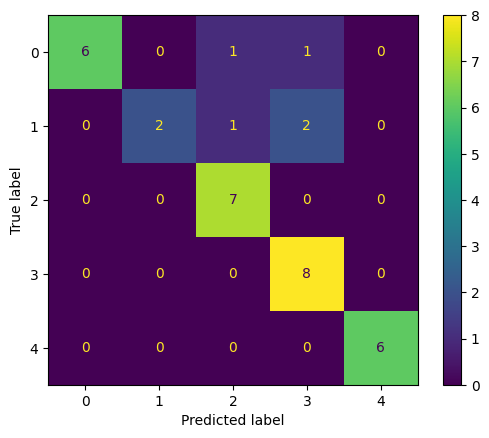


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['fear(3)']



In [65]:
# select the features
df_5emos_3_eplpcmfcc = df_5emos.filter(regex='energy_|pitch_|lpcmfccs_|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_5emos_3_eplpcmfcc, verbose=False, test_size=0.1)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

Finally, it seems like the model with Energy, pitch, lpccs, and mfccs is the strongest. It could be that the computation of lpcmfccs is not sufficient enough to hold both advantages of lpccs and mfccs in this case. We will try if further finetuning for the best model still increases its performance.

### Hyperparameter Optimization best model 

In [9]:
# train model on best features again

# select the features
df_3_eplm = df_3.filter(regex='energy_|pitch_|lpccs_|^mfccs|label')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_3_eplm, verbose=False, test_size=0.3)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# define the grid for the hyperparameter search
grid_vals = { 'C': [0.01, 0.1, 1, 10], 
            'gamma': [0.01, 0.1, 1, 10, 'scale', 'auto'],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'class_weight': ['balanced', None], 
            'decision_function_shape': ['ovo', 'ovr']
            }

run_gridsearchCV(svm_model, grid_vals, X_train, y_train, name_spec='paper3')

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_we

[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovo, gamma=scale

[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=0.1, kernel=sigmoid; tot

[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=poly; total t

[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovo, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=0.01, class_weight=None, deci

[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=0.01, 

[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=0.01, class_weight=None, decision_function_shape=ovr, gamma=auto, kernel=rbf; total time=   0.0

[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovo, gamma=10, kernel=linear; total time=

[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=sigmoid; tot

[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=poly; total 

[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=o

[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=No

[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, class_

[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balance

[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] EN

[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=  

[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovo, gamma=1,

[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function

[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision_function_shape=ovr, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=1, class_weight=None, decision

[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weig

[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=0.01, kernel=rbf; total 

[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=10, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=10, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=linear; total time=  

[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, deci

[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovo, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END C=10, class_weight=None, dec

[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=rbf; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=ovr, gamma=10, kernel=poly; total time=   0.0s
[CV] END C=10, class_weight=None, decision_function_shape=o


Evaluation: f1_score
90.77% for the train data
77.98% for the test data

Evaluation: accuracy_score
90.91% for the train data
78.88% for the test data

Evaluation: precision_score
91.76% for the train data
79.71% for the test data

Evaluation: recall_score
90.07% for the train data
77.31% for the test data

Evaluation: confusion_matrix of test predictions


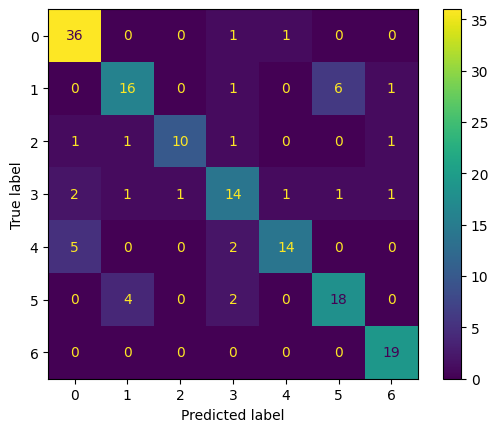


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [10]:
svm_best_model_paper3 = load_model('SVC', 'f1_macro', name_spec='paper3')
model_eval(svm_best_model_paper3, X_train, X_test, y_train, y_test, confusion=True)

In [11]:
params_best_svm = svm_best_model_paper3.get_params()
params_best_svm

{'C': 0.01,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovo',
 'degree': 3,
 'gamma': 0.01,
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Even though we already achieve quite good results, we can still see that the model is overfitting to our data. Therefore, we will apply some dimensionality reduction/ feature selection.
## Dimensionality Reduction (Feature Selection)
For this, we also load the whole dataset with all statistics.

In [39]:
# load the data
df = pd.read_pickle('../results/df_prep_numerical_only.pkl')
print(df.columns)
df_all_stats = pd.read_pickle('../results/df_prep_numerical_only_all_stats.pkl')
print(df_all_stats.columns)

Index(['duration', 'mean', 'median', 'max', 'min', 'var', 'std',
       'speaking_rate', 'articulation_rate', 'asd',
       ...
       'lpc_local2_min', 'lpc_local3_mean', 'lpc_local3_var', 'lpc_local3_max',
       'lpc_local3_min', 'lpc_local4_mean', 'lpc_local4_var', 'lpc_local4_max',
       'lpc_local4_min', 'label'],
      dtype='object', length=270)
Index(['duration', 'mean', 'median', 'max', 'min', 'var', 'std',
       'speaking_rate', 'articulation_rate', 'asd',
       ...
       'value_rising_energy_iqr', 'value_falling_energy_iqr',
       'duration_rising_pitch_iqr', 'duration_falling_pitch_iqr',
       'value_rising_pitch_iqr', 'value_falling_pitch_iqr', 'skew_log_pitch',
       'range_log_pitch', 'range_log_energy', 'label'],
      dtype='object', length=596)


### 1) PCA

In [40]:
# create the dataset of principal components
pca = PCA(0.9)
principalComponents = pca.fit_transform(df_3.drop('label', axis=1))

principal_df = pd.DataFrame(data = principalComponents)
principal_df = pd.concat([principal_df, df_3[['label']]], axis = 1)

In [41]:
len(pca.explained_variance_ratio_)

34

In [42]:
pca.explained_variance_ratio_.sum()

0.9009038857850062


Evaluation: f1_score
89.24% for the train data
75.08% for the test data

Evaluation: accuracy_score
89.19% for the train data
75.93% for the test data

Evaluation: precision_score
90.69% for the train data
80.83% for the test data

Evaluation: recall_score
88.33% for the train data
74.02% for the test data

Evaluation: confusion_matrix of test predictions


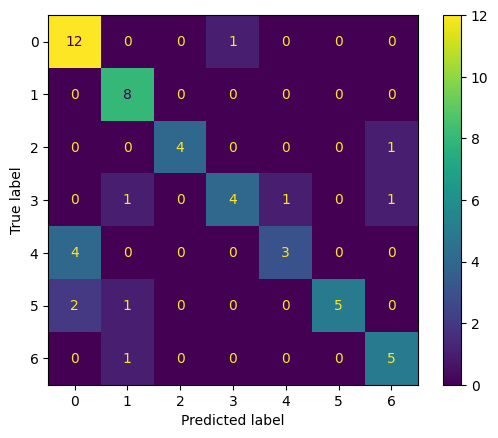


Hard cases for the model:

Label: anger(0)
Hard cases of false positives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: neutral(5)
Hard cases of false negatives: ['anger(0)']



In [43]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(principal_df, verbose=False, test_size=0.1)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

Keeping 90% variance, we can end up with a good result for train and test data while using only 34 features (principal components) instead of 186! (89.47% compared to 95.27% F1 macro for train, 74.35% compared to 74.68% F1 macro for test

In [44]:
# try with all created numerical features:

# create the dataset of principal components
pca = PCA(0.9)
principalComponents = pca.fit_transform(df.drop('label', axis=1))

principal_df = pd.DataFrame(data = principalComponents)
principal_df = pd.concat([principal_df, df[['label']]], axis = 1)

In [45]:
print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

47
[0.23196967 0.12281907 0.0675241  0.05374552 0.04676521 0.0309253
 0.03047724 0.02491181 0.02109577 0.02016766 0.01894271 0.01593638
 0.01406514 0.01367311 0.01212756 0.01102046 0.01076505 0.00986852
 0.00893571 0.0084468  0.00815084 0.00735054 0.00726901 0.00696108
 0.00654394 0.0058341  0.00558154 0.0052351  0.00496386 0.00481289
 0.00473103 0.00457154 0.00435873 0.0043216  0.00426994 0.00411253
 0.00408326 0.00396558 0.00385178 0.00380607 0.00372984 0.00350884
 0.00349901 0.00331704 0.00319952 0.00313462 0.00307176]



Evaluation: f1_score
94.14% for the train data
82.25% for the test data

Evaluation: accuracy_score
94.18% for the train data
83.33% for the test data

Evaluation: precision_score
94.97% for the train data
87.30% for the test data

Evaluation: recall_score
93.51% for the train data
80.99% for the test data

Evaluation: confusion_matrix of test predictions


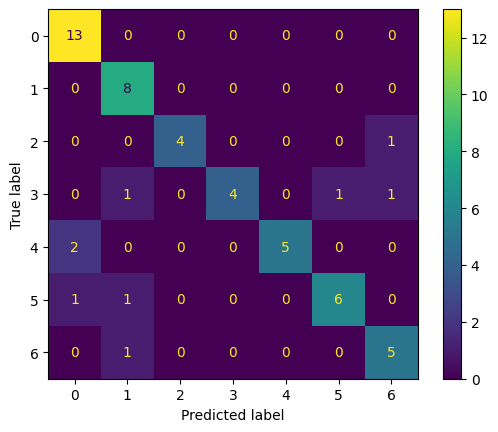


Hard cases for the model:

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [46]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(principal_df, verbose=False, test_size=0.1)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
92.18% for the train data
78.21% for the test data

Evaluation: accuracy_score
92.25% for the train data
78.88% for the test data

Evaluation: precision_score
93.35% for the train data
82.03% for the test data

Evaluation: recall_score
91.51% for the train data
76.74% for the test data

Evaluation: confusion_matrix of test predictions


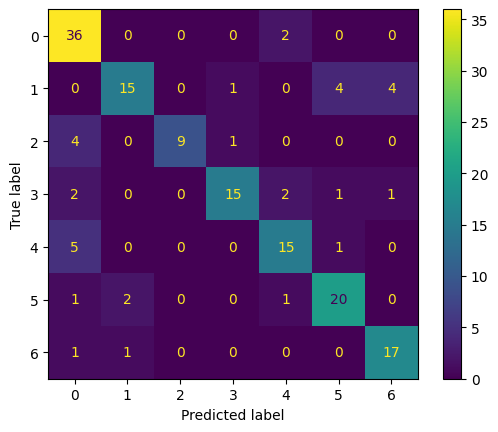


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [47]:
# with changed train/test ratio

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(principal_df, verbose=False, test_size=0.3)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

In [27]:
# and with all statistical features

# create the dataset of principal components
pca = PCA(0.9)
principalComponents = pca.fit_transform(df_all_stats.drop('label', axis=1))

principal_df = pd.DataFrame(data = principalComponents)
principal_df = pd.concat([principal_df, df[['label']]], axis = 1)

print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

103
[0.1371097  0.1225378  0.04878109 0.04306813 0.03503977 0.03143388
 0.02841167 0.02122009 0.01921022 0.01644826 0.01569456 0.01476704
 0.01442153 0.01311755 0.01305086 0.01188505 0.01135937 0.01061576
 0.01011364 0.00922488 0.00884234 0.00823372 0.00770304 0.00751619
 0.0071806  0.00701369 0.00693512 0.00659679 0.00637725 0.00610694
 0.00588616 0.00584404 0.00550799 0.00536687 0.00504853 0.00482218
 0.00472164 0.00452798 0.00438488 0.00430476 0.00414801 0.00408645
 0.0040593  0.00381127 0.00378764 0.00361238 0.00355297 0.00350895
 0.00345933 0.00336829 0.00329617 0.00314747 0.00311828 0.00304889
 0.0029914  0.00296533 0.00284535 0.0028187  0.00276443 0.0027123
 0.00267024 0.00261958 0.00260387 0.00251982 0.00244606 0.00243382
 0.0023608  0.00232406 0.00227299 0.00225475 0.00222684 0.00218453
 0.0021589  0.00212355 0.00208363 0.00205167 0.00204371 0.00196448
 0.00195309 0.00193649 0.00193473 0.00188694 0.00186865 0.00183865
 0.00183572 0.00179142 0.00176027 0.00173093 0.00172303 0.0


Evaluation: f1_score
98.21% for the train data
77.15% for the test data

Evaluation: accuracy_score
98.13% for the train data
77.78% for the test data

Evaluation: precision_score
98.66% for the train data
81.70% for the test data

Evaluation: recall_score
97.85% for the train data
75.12% for the test data

Evaluation: confusion_matrix of test predictions


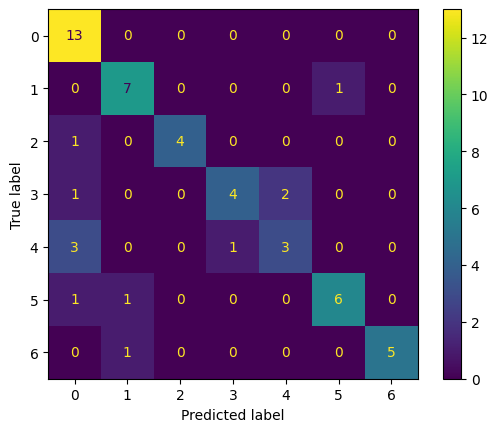


Hard cases for the model:

Label: fear(3)
Hard cases of false negatives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']



In [49]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(principal_df, verbose=False, test_size=0.1)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
97.63% for the train data
76.77% for the test data

Evaluation: accuracy_score
97.59% for the train data
77.02% for the test data

Evaluation: precision_score
98.11% for the train data
79.19% for the test data

Evaluation: recall_score
97.27% for the train data
75.59% for the test data

Evaluation: confusion_matrix of test predictions


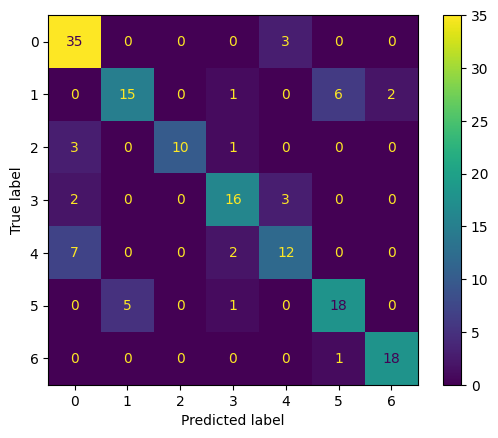


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [50]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(principal_df, verbose=False, test_size=0.3)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

### 2) Featurewiz

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (535, 187)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
##############################################

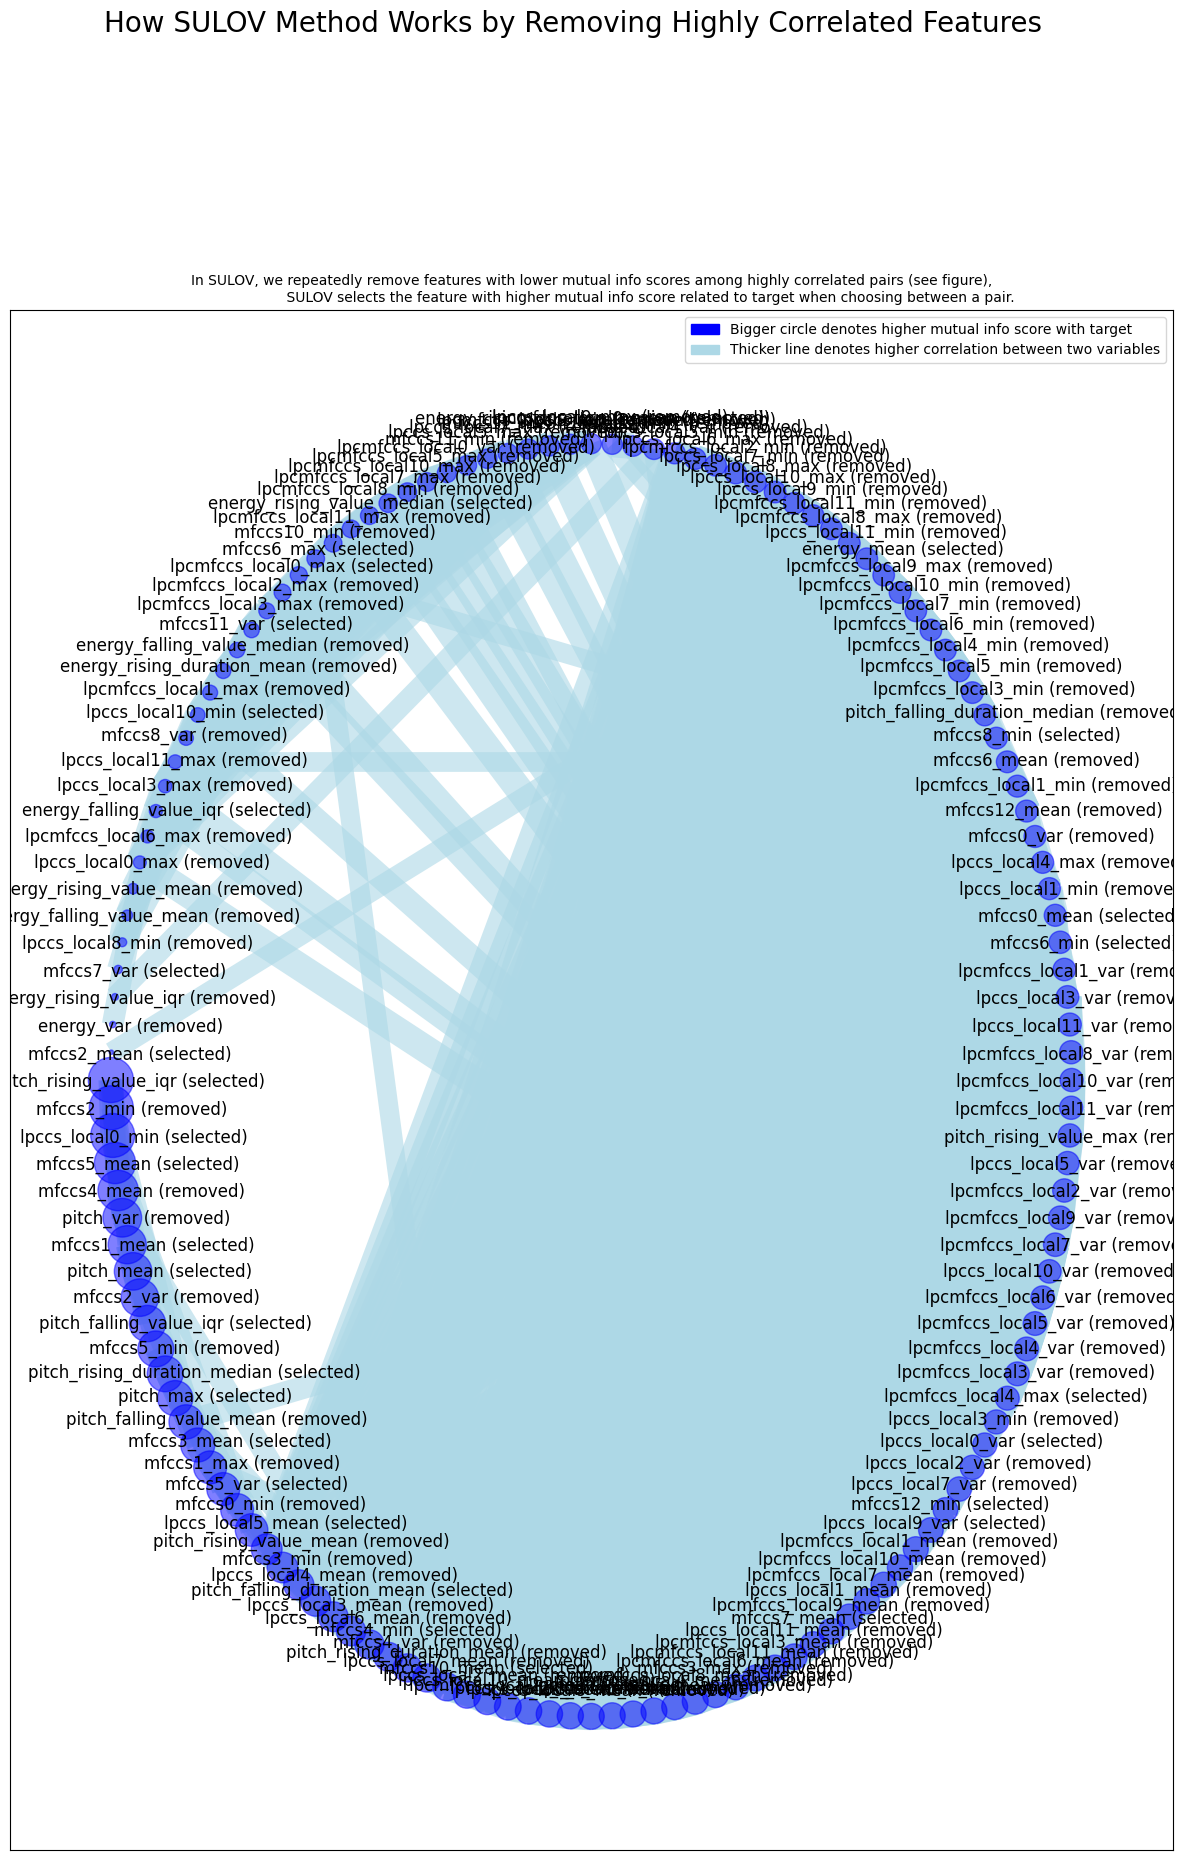

Time taken for SULOV method = 3 seconds
    Adding 0 categorical variables to reduced numeric variables  of 75
Finally 75 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 75 
    Taking top 27 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
        using 75 variables...
            selecting 14 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds
        using 60 variables...
            selecting 12 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds


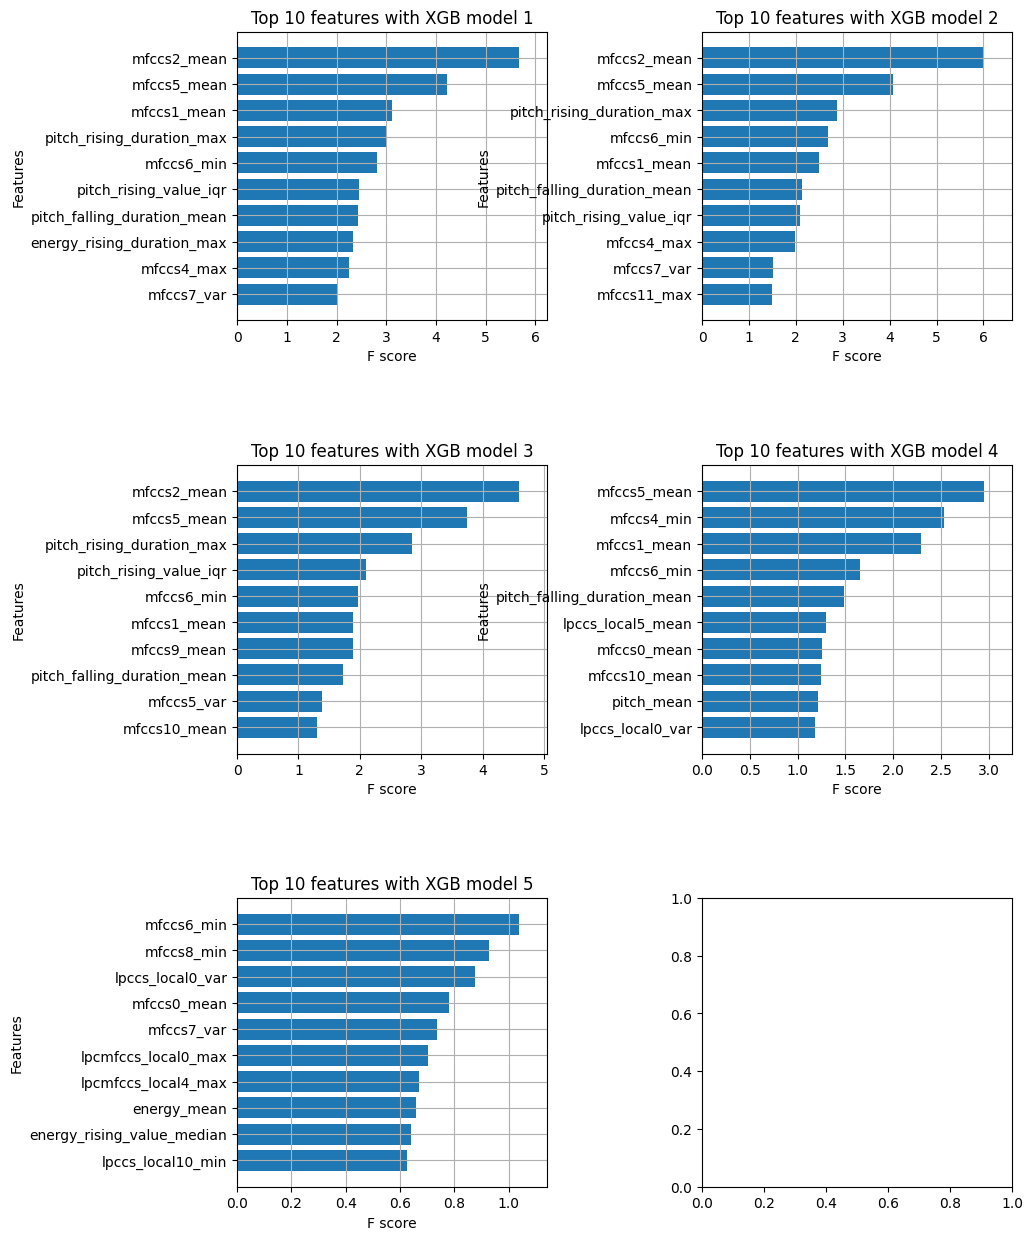

    Completed XGBoost feature selection in 2 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 20 important features:
['mfccs2_mean', 'mfccs5_mean', 'mfccs1_mean', 'pitch_rising_duration_max', 'mfccs6_min', 'pitch_rising_value_iqr', 'pitch_falling_duration_mean', 'energy_rising_duration_max', 'mfccs4_max', 'mfccs7_var', 'lpcmfccs_local0_max', 'mfccs0_mean', 'energy_falling_value_max', 'mfccs9_min', 'mfccs11_max', 'mfccs9_mean', 'mfccs5_var', 'mfccs10_mean', 'mfccs4_min', 'lpccs_local5_mean']
Total Time taken for featurewiz selection = 9 seconds
Output contains a list of 20 important features and a train dataframe


In [51]:
# automatic feature selection by using featurewiz package
target = 'label'
 
features, df_reduced = featurewiz(df_3, target, corr_limit=0.7, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

In [52]:
features

['mfccs2_mean',
 'mfccs5_mean',
 'mfccs1_mean',
 'pitch_rising_duration_max',
 'mfccs6_min',
 'pitch_rising_value_iqr',
 'pitch_falling_duration_mean',
 'energy_rising_duration_max',
 'mfccs4_max',
 'mfccs7_var',
 'lpcmfccs_local0_max',
 'mfccs0_mean',
 'energy_falling_value_max',
 'mfccs9_min',
 'mfccs11_max',
 'mfccs9_mean',
 'mfccs5_var',
 'mfccs10_mean',
 'mfccs4_min',
 'lpccs_local5_mean']


Evaluation: f1_score
86.44% for the train data
62.66% for the test data

Evaluation: accuracy_score
86.49% for the train data
66.67% for the test data

Evaluation: precision_score
88.01% for the train data
72.89% for the test data

Evaluation: recall_score
85.80% for the train data
65.05% for the test data

Evaluation: confusion_matrix of test predictions


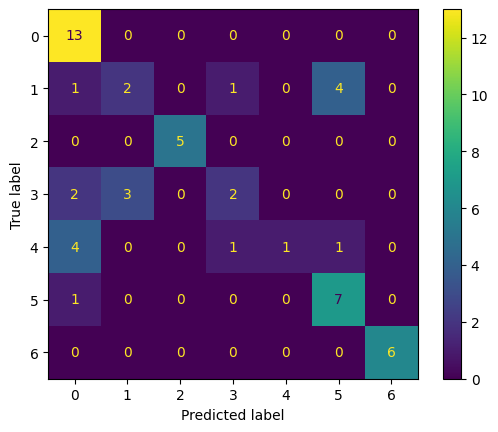


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['fear(3)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)', 'boredom(1)']
Hard cases of false positives: ['boredom(1)', 'happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [53]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced, verbose=False, test_size=0.1)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
86.85% for the train data
65.16% for the test data

Evaluation: accuracy_score
86.63% for the train data
66.46% for the test data

Evaluation: precision_score
88.13% for the train data
67.16% for the test data

Evaluation: recall_score
86.09% for the train data
65.33% for the test data

Evaluation: confusion_matrix of test predictions


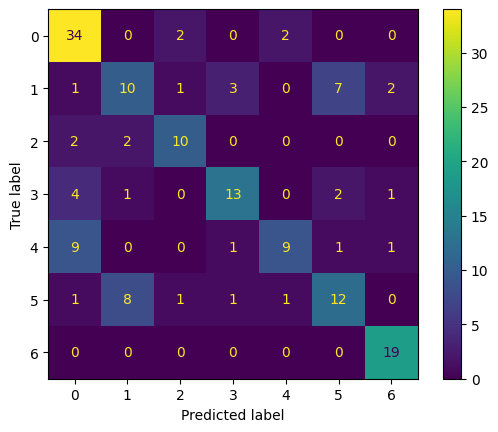


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [54]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced, verbose=False, test_size=0.3)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (535, 270)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
##############################################

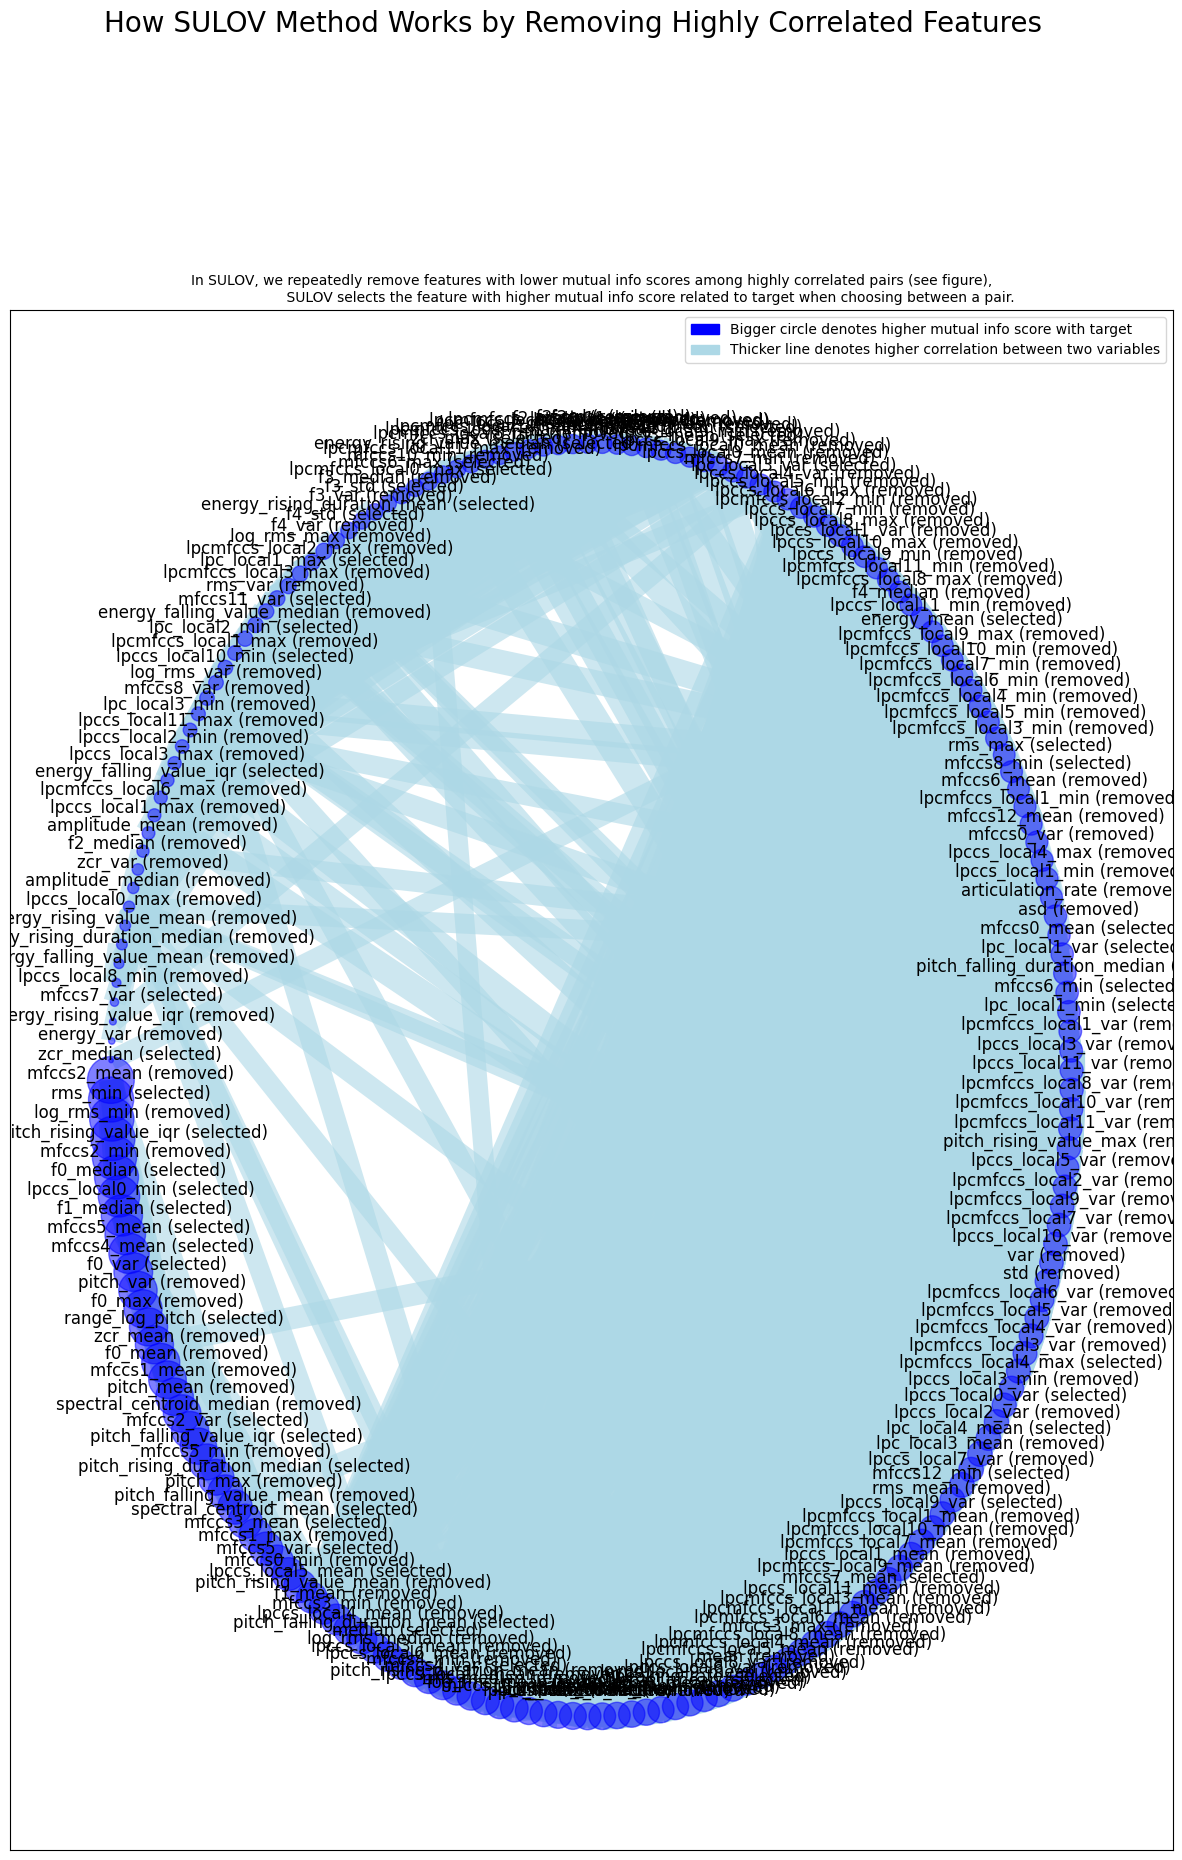

Time taken for SULOV method = 4 seconds
    Adding 0 categorical variables to reduced numeric variables  of 114
Finally 114 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 114 
    Taking top 39 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
        using 114 variables...
            selecting 25 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds
        using 91 variables...
            selecting 22 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seco

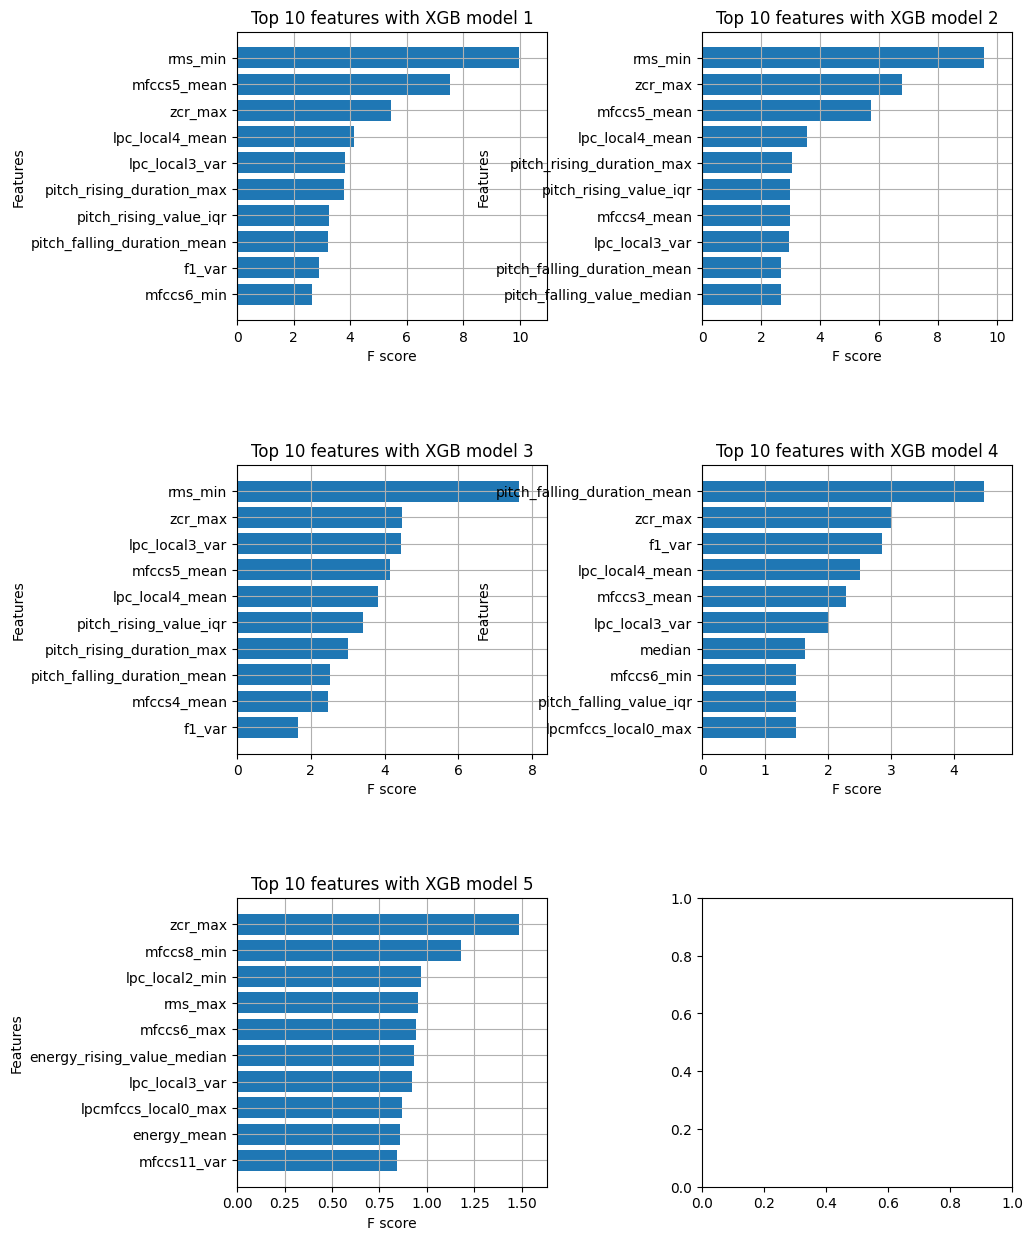

    Completed XGBoost feature selection in 2 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 34 important features. Too many to print...
Total Time taken for featurewiz selection = 9 seconds
Output contains a list of 34 important features and a train dataframe


In [55]:
# try with created numerical features:

# automatic feature selection by using featurewiz package
target = 'label'
 
features_all, df_reduced_all = featurewiz(df, target, corr_limit=0.7, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

In [56]:
features_all

['rms_min',
 'mfccs5_mean',
 'zcr_max',
 'lpc_local4_mean',
 'lpc_local3_var',
 'pitch_rising_duration_max',
 'pitch_rising_value_iqr',
 'pitch_falling_duration_mean',
 'f1_var',
 'mfccs6_min',
 'pitch_falling_duration_iqr',
 'mfccs4_mean',
 'mfccs6_var',
 'lpccs_local5_mean',
 'lpccs_local4_min',
 'lpcmfccs_local0_max',
 'energy_falling_value_max',
 'speaking_rate',
 'lpc_local4_var',
 'zcr_median',
 'mfccs4_max',
 'pitch_falling_value_median',
 'lpc_local1_min',
 'energy_rising_duration_max',
 'lpc_local4_min',
 'mfccs7_var',
 'pitch_falling_value_iqr',
 'f0_median',
 'rms_max',
 'f1_median',
 'lpc_local2_min',
 'mfccs3_mean',
 'median',
 'mfccs8_min']


Evaluation: f1_score
91.70% for the train data
80.53% for the test data

Evaluation: accuracy_score
91.68% for the train data
79.63% for the test data

Evaluation: precision_score
92.76% for the train data
86.53% for the test data

Evaluation: recall_score
91.14% for the train data
79.08% for the test data

Evaluation: confusion_matrix of test predictions


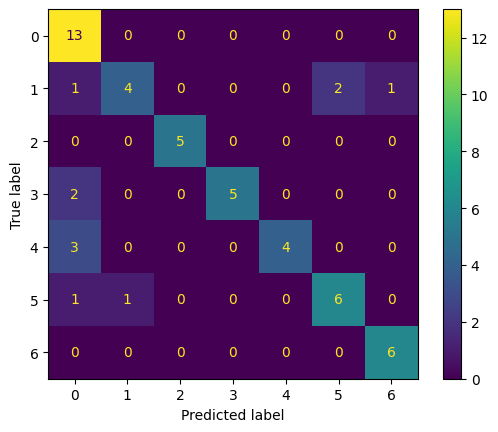


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [57]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced_all, verbose=False, test_size=0.1)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

With only 34 features we can achieve 91.70% F1 macro for the train data and 80.53% F1 macro for the test data!


Evaluation: f1_score
89.65% for the train data
73.24% for the test data

Evaluation: accuracy_score
89.57% for the train data
74.53% for the test data

Evaluation: precision_score
91.52% for the train data
76.80% for the test data

Evaluation: recall_score
89.02% for the train data
72.48% for the test data

Evaluation: confusion_matrix of test predictions


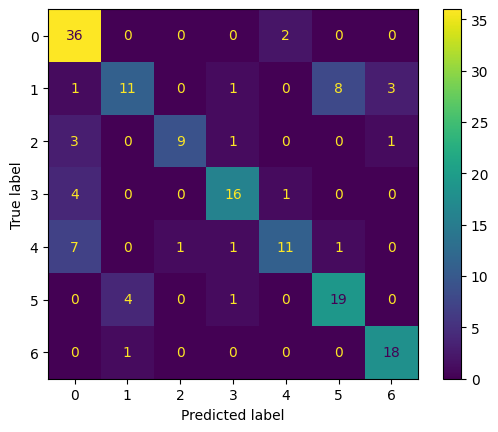


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [58]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced_all, verbose=False, test_size=0.3)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (535, 596)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
##############################################

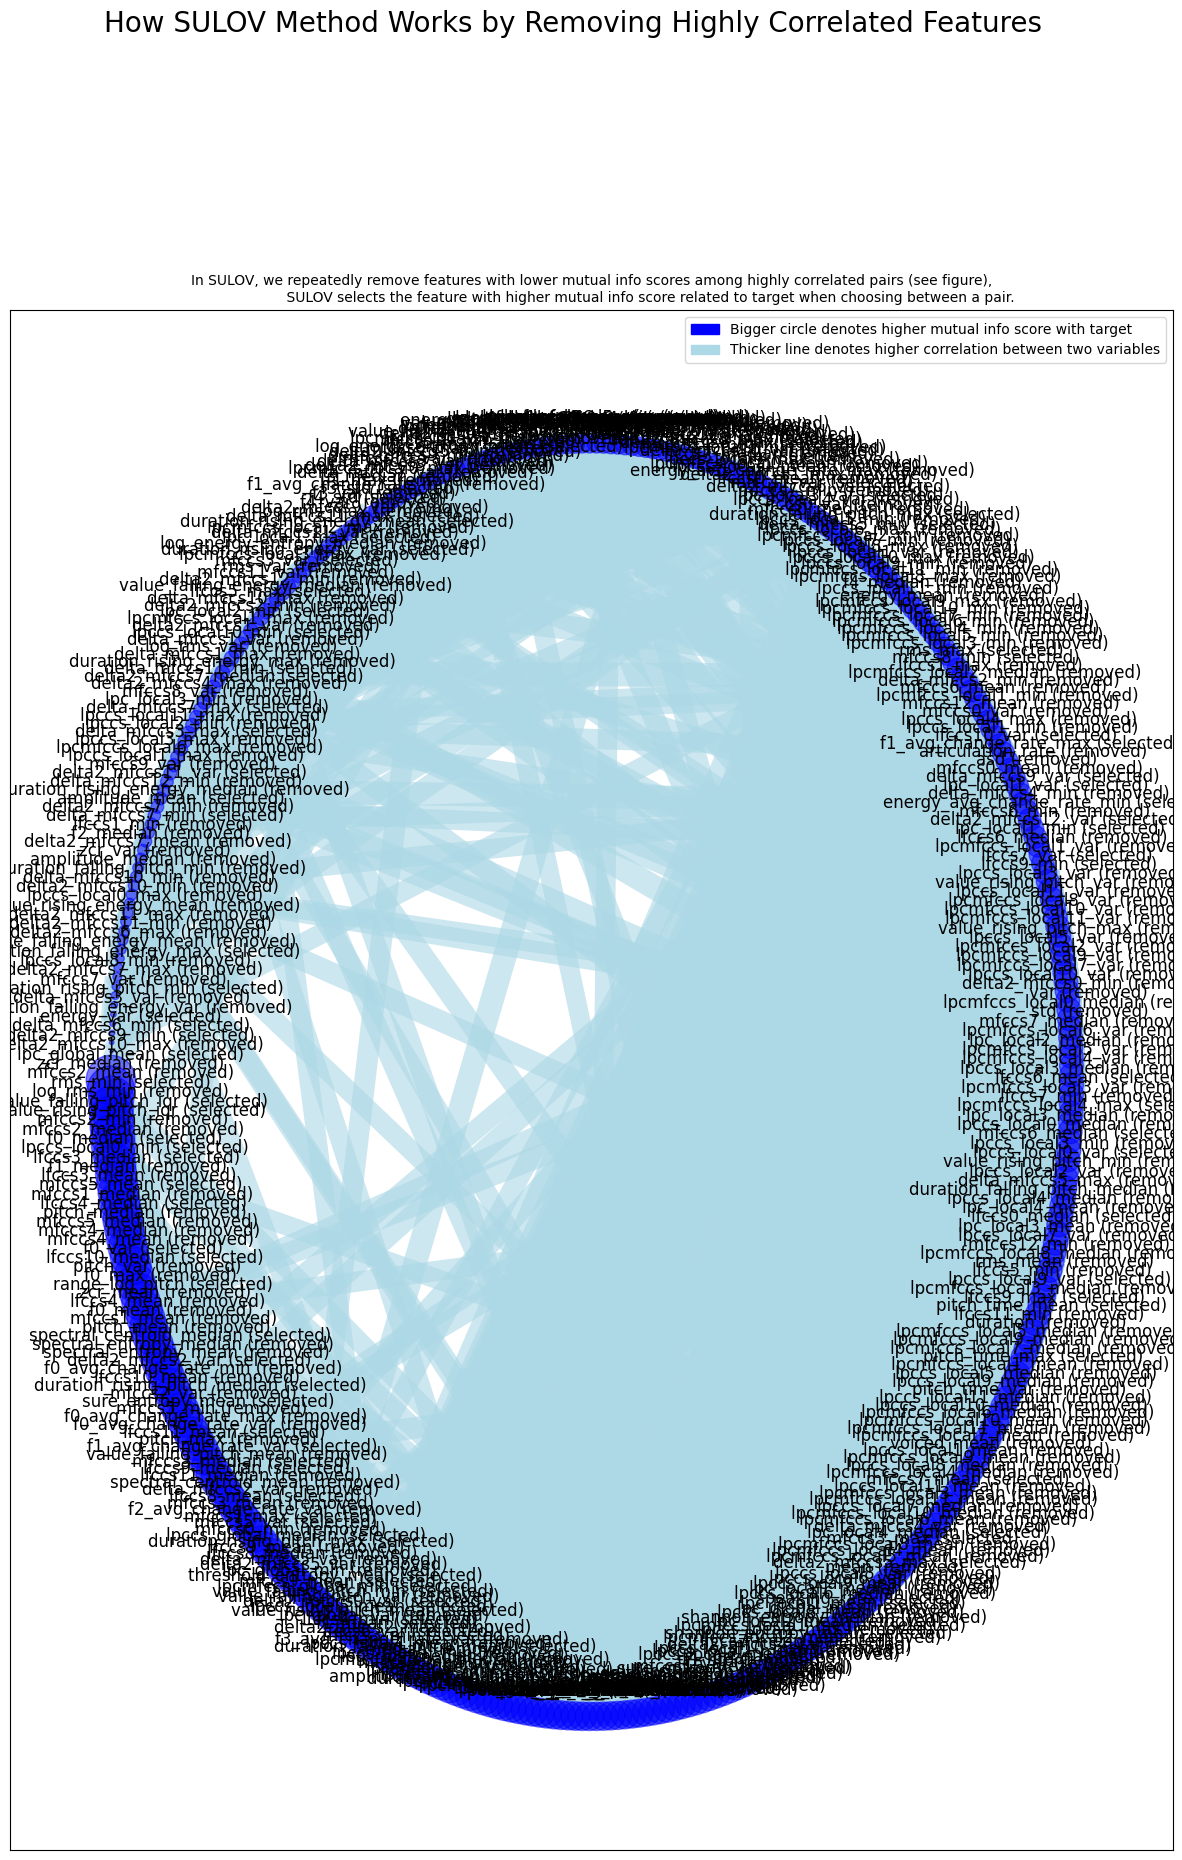

Time taken for SULOV method = 7 seconds
    Adding 0 categorical variables to reduced numeric variables  of 298
Finally 298 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 298 
    Taking top 89 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
        using 298 variables...
            selecting 56 features in this iteration
            Time taken for regular XGBoost feature selection = 3 seconds
        using 238 variables...
            selecting 46 features in this iteration
            Time taken for regular XGBoost feature selection = 2 sec

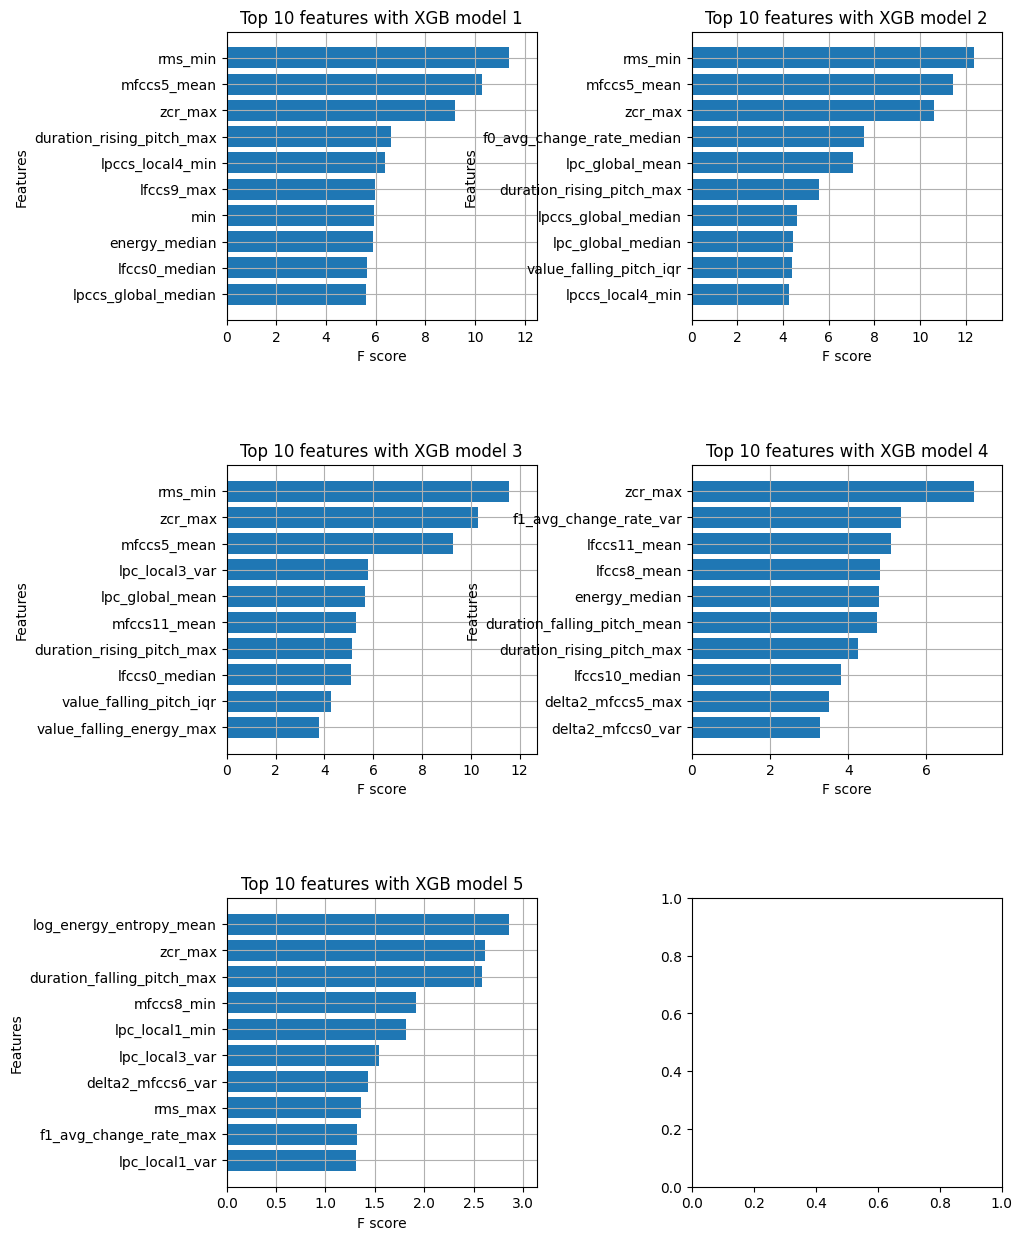

    Completed XGBoost feature selection in 2 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 97 important features. Too many to print...
Total Time taken for featurewiz selection = 18 seconds
Output contains a list of 97 important features and a train dataframe


In [59]:
# try with created numerical features (all stats):

# automatic feature selection by using featurewiz package
target = 'label'
 
features_all, df_reduced_all = featurewiz(df_all_stats, target, corr_limit=0.7, verbose=2, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

In [11]:
# save dataframe with most important features
df_reduced_all.to_pickle('../results/df_prep_most_important97.pkl')

In [60]:
features_all

['rms_min',
 'mfccs5_mean',
 'zcr_max',
 'duration_rising_pitch_max',
 'lpccs_local4_min',
 'lfccs9_max',
 'min',
 'energy_median',
 'lfccs0_median',
 'lpccs_global_median',
 'lpc_global_mean',
 'value_falling_energy_max',
 'mfccs11_mean',
 'f1_min',
 'lpc_local3_var',
 'lpccs_local0_var',
 'f0_avg_change_rate_median',
 'lfccs9_median',
 'delta_mfccs0_min',
 'value_falling_pitch_iqr',
 'lpc_local1_mean',
 'f1_avg_change_rate_var',
 'threshold_entropy_var',
 'mfccs3_max',
 'f2_mean',
 'lfccs7_var',
 'lfccs9_var',
 'delta_mfccs5_median',
 'mfccs4_max',
 'energy_var',
 'delta2_mfccs3_min',
 'lpccs_local5_mean',
 'shannon_entropy_mean',
 'delta2_mfccs5_mean',
 'delta_mfccs4_median',
 'f3_mean',
 'mfccs5_var',
 'voiced_var',
 'duration_rising_energy_var',
 'lpc_local4_median',
 'f0_var',
 'lpcmfccs_global_min',
 'delta2_mfccs2_var',
 'duration_falling_pitch_iqr',
 'delta2_mfccs7_var',
 'lfccs6_mean',
 'delta2_mfccs6_median',
 'f3_avg_change_rate_median',
 'delta_mfccs6_median',
 'lfccs4_var


Evaluation: f1_score
97.15% for the train data
77.21% for the test data

Evaluation: accuracy_score
97.09% for the train data
77.78% for the test data

Evaluation: precision_score
97.53% for the train data
86.49% for the test data

Evaluation: recall_score
96.88% for the train data
74.64% for the test data

Evaluation: confusion_matrix of test predictions


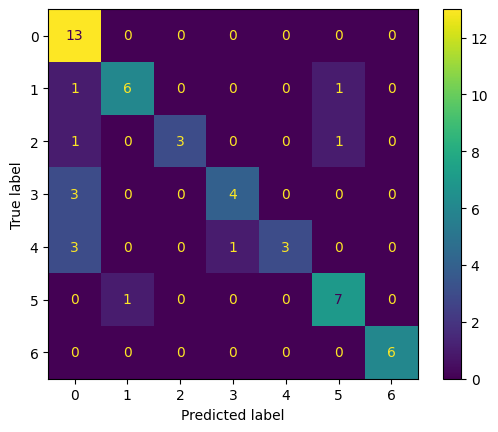


Hard cases for the model:

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [61]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced_all, verbose=False, test_size=0.1)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
98.27% for the train data
80.92% for the test data

Evaluation: accuracy_score
98.13% for the train data
81.37% for the test data

Evaluation: precision_score
98.62% for the train data
83.30% for the test data

Evaluation: recall_score
98.02% for the train data
79.65% for the test data

Evaluation: confusion_matrix of test predictions


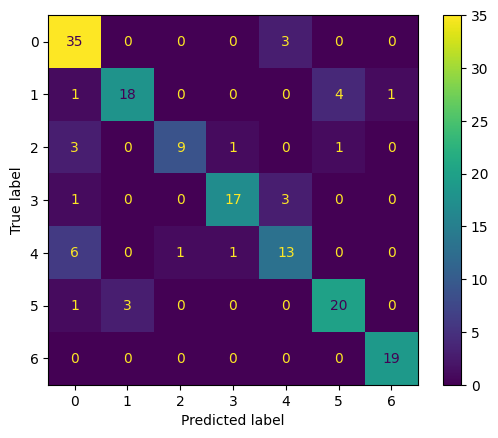


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [62]:
# with different split size

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced_all, verbose=False, test_size=0.3)

# train the model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# evaluate the model
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

In [17]:
# save model
pickle.dump(svm_model, open('../results/models/SVC_f1_macro_best_model_most_important97.pkl', 'wb'))

# Paper 2
### Liu et al. (2018) "Speech emotion recognition based on feature selection and extreme learning machine decision tree"

In [27]:
# read saved dataframe
df = pd.read_pickle('../results/df_prep_numerical_only_all_stats.pkl')

# feature selection
df_paper2 = df[['f0_max', 'f0_var', 'amplitude_max', 'energy_mean', 'amplitude_mean', 'zcr_mean', 'speaking_rate', 
                'spectral_centroid_mean', 'spectral_centroid_mean', 'f1_max', 'f1_mean', 'f1_std', 'f2_max', 'f2_mean', 
                'f2_std', 'f3_max', 'f3_std', 'f3_mean', 'f0_avg_change_rate_mean', 'energy_avg_change_rate_mean', 
                'amplitude_avg_change_rate_mean', 'f1_avg_change_rate_mean', 'f2_avg_change_rate_mean', 
                'f3_avg_change_rate_mean', 'label']]
df_paper2 = pd.concat([df_paper2, df.filter(regex='^(delta|mfccs|lfccs)\w+_mean$')], axis=1)
print(f'The dataframe has {len(df_paper2.columns)} columns.')
df_paper2.columns

The dataframe has 76 columns.


Index(['f0_max', 'f0_var', 'amplitude_max', 'energy_mean', 'amplitude_mean',
       'zcr_mean', 'speaking_rate', 'spectral_centroid_mean',
       'spectral_centroid_mean', 'f1_max', 'f1_mean', 'f1_std', 'f2_max',
       'f2_mean', 'f2_std', 'f3_max', 'f3_std', 'f3_mean',
       'f0_avg_change_rate_mean', 'energy_avg_change_rate_mean',
       'amplitude_avg_change_rate_mean', 'f1_avg_change_rate_mean',
       'f2_avg_change_rate_mean', 'f3_avg_change_rate_mean', 'label',
       'mfccs0_mean', 'mfccs1_mean', 'mfccs2_mean', 'mfccs3_mean',
       'mfccs4_mean', 'mfccs5_mean', 'mfccs6_mean', 'mfccs7_mean',
       'mfccs8_mean', 'mfccs9_mean', 'mfccs10_mean', 'mfccs11_mean',
       'mfccs12_mean', 'delta_mfccs0_mean', 'delta_mfccs1_mean',
       'delta_mfccs2_mean', 'delta_mfccs3_mean', 'delta_mfccs4_mean',
       'delta_mfccs5_mean', 'delta_mfccs6_mean', 'delta_mfccs7_mean',
       'delta_mfccs8_mean', 'delta_mfccs9_mean', 'delta_mfccs10_mean',
       'delta_mfccs11_mean', 'delta_mfccs12_me

In [28]:
# create train/test split
X_train, X_test, y_train, y_test = load_train_test_data(df_paper2, test_size=0.3)

A snippet of the data:


f0_max    f0_var  amplitude_max  energy_mean  amplitude_mean  zcr_mean  \
383  1.231016  0.681296       0.733353     0.317044        0.918490  1.340242   
180 -1.358694 -0.752244      -1.397406     1.236712       -0.574499 -1.911344   
447 -0.977852 -0.570377      -2.124781     0.816668        0.640429  0.972242   
409 -0.607699 -0.357108       0.733353     0.392123       -0.020029  0.664951   
268  0.723941  0.865626       0.733353     0.515033        0.189601  0.669922   

     speaking_rate  spectral_centroid_mean  spectral_centroid_mean    f1_max  \
383       0.446530                0.506801                0.506801  0.749154   
180       0.214744               -0.330219               -0.330219  0.422193   
447       1.541140                1.273873                1.273873  2.563538   
409      -0.034375                0.403946                0.403946 -0.834384   
268       0.738204                0.203537                0.203537  1.938499   

      f1_mean    f1_std    f2_max   f2_mean    f2_std    f3_max    f3_std  \
383 -0.095229 -0.520755 -0.520892  0.787750  0.538977  0.148376 -0.276466   
180  0.956602  2.375949  1.926849 -0.373516  2.600882  1.150584  1.938132   
447  1.474111  3.109221  0.682151  1.123658  2.237048  0.889632  2.728702   
409  0.321871 -0.759715 -0.835770 -0.989488 -1.409870 -0.874743 -1.124206   
268  1.243244 -0.616808  0.151561 -0.822185  0.500952  0.545710 -0.551651   

      f3_mean  f0_avg_change_rate_mean  energy_avg_change_rate_mean  \
383 -0.125812                  -0.3072                     0.062564   
180  1.509627                  -0.3072                     0.080092   
447  1.837903                  -0.3072                     2.478982   
409 -0.660298                  -0.3072                     0.061564   
268  0.253051                  -0.3072                     0.062067   

     amplitude_avg_change_rate_mean  f1_avg_change_rate_mean  \
383                        0.847746                -0.124972   
180                        0.818186                -0.635571   
447                       -0.654345                -0.537989   
409                       -1.115963                -0.542370   
268                        0.741523                -1.618366   

     f2_avg_change_rate_mean  f3_avg_change_rate_mean  mfccs0_mean  \
383                 0.021752                -0.510516     0.457343   
180                 0.047973                -0.347630     0.277321   
447                -1.116068                -0.406939     3.014764   
409                -1.240215                -0.742762    -0.234994   
268                -1.353465                -1.364033     0.450180   

     mfccs1_mean  mfccs2_mean  mfccs3_mean  mfccs4_mean  mfccs5_mean  \
383    -0.960655    -0.217877    -0.313628    -0.921892    -0.883268   
180     1.641698     1.122424    -0.045314     1.454875     2.981771   
447    -0.303937     1.202789    -0.264685     0.829963     2.016252   
409    -0.327325    -1.373864    -0.956468    -0.583640    -0.067690   
268    -0.634537    -1.093820    -1.853200    -1.693030    -1.481929   

     mfccs6_mean  mfccs7_mean  mfccs8_mean  mfccs9_mean  mfccs10_mean  \
383    -0.448372     0.476108    -1.403384    -1.655430     -0.626265   
180     2.726794    -0.098594     0.998729     0.829990      0.869278   
447     1.422007     1.494238     0.793258     0.850926     -0.040726   
409    -0.452259    -0.952026     0.207580     0.341977      0.846171   
268     1.162772    -1.546099    -0.413845     0.410130     -1.238801   

     mfccs11_mean  mfccs12_mean  delta_mfccs0_mean  delta_mfccs1_mean  \
383     -1.457795      0.098980           0.931772           0.535687   
180      0.474646      1.036108           0.205226          -0.064679   
447     -0.111309     -0.601218           0.842387          -0.536854   
409     -0.433176     -0.695221          -1.529378          -1.021420   
268      1.053325     -1.282359           0.140378           1.460620   

     delta_mfccs2_mean  delta_mf

There are 374 entries with 75 columns in the training data.
There are 161 entries with 75 columns in the testing data.


## ELM Decision Tree
Extreme Learning Machines are supposedly really good for generalization and fast training with one hidden layer only and many hidden units. From "High Performance Extreme Learning Machines: A Complete Toolbox for Big Data Applications" in IEEE Access. http://ieeexplore.ieee.org/xpl/articleDetails.jsp?arnumber=7140733&newsearch=true&queryText=High%20Performance%20Extreme%20Learning%20Machines
<br> Using scikit-elm: https://scikit-elm.readthedocs.io/en/latest/generated/skelm.ELMClassifier.html#skelm.ELMClassifier


Evaluation: f1_score
94.71% for the train data
66.80% for the test data

Evaluation: accuracy_score
94.65% for the train data
67.08% for the test data

Evaluation: precision_score
95.25% for the train data
69.00% for the test data

Evaluation: recall_score
94.38% for the train data
65.82% for the test data

Evaluation: confusion_matrix of test predictions


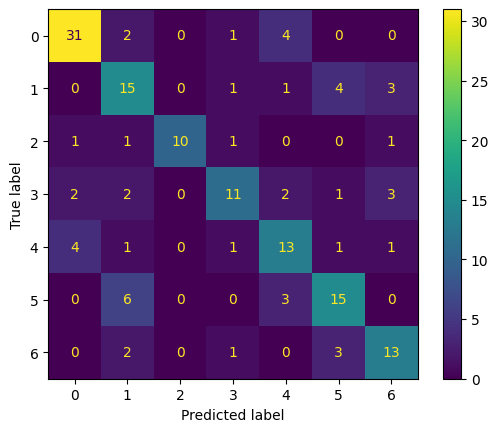


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [39]:
# with scikit-elm
elm = skelm.ELMClassifier(random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
95.37% for the train data
66.57% for the test data

Evaluation: accuracy_score
95.45% for the train data
66.46% for the test data

Evaluation: precision_score
95.76% for the train data
67.88% for the test data

Evaluation: recall_score
95.14% for the train data
65.70% for the test data

Evaluation: confusion_matrix of test predictions


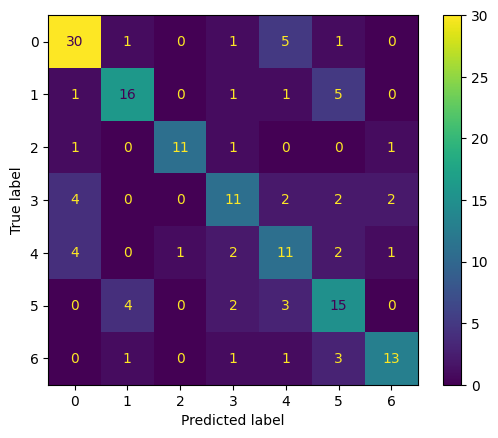


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']



In [47]:
elm = skelm.ELMClassifier(ufunc='sigm', random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
97.41% for the train data
73.09% for the test data

Evaluation: accuracy_score
97.59% for the train data
73.91% for the test data

Evaluation: precision_score
97.77% for the train data
76.61% for the test data

Evaluation: recall_score
97.11% for the train data
71.74% for the test data

Evaluation: confusion_matrix of test predictions


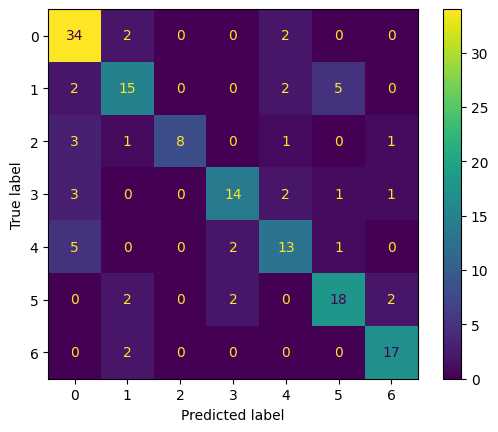


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [59]:
elm = skelm.ELMClassifier(pairwise_metric='euclidean', random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
91.73% for the train data
80.27% for the test data

Evaluation: accuracy_score
91.98% for the train data
80.75% for the test data

Evaluation: precision_score
93.16% for the train data
82.24% for the test data

Evaluation: recall_score
90.85% for the train data
79.10% for the test data

Evaluation: confusion_matrix of test predictions


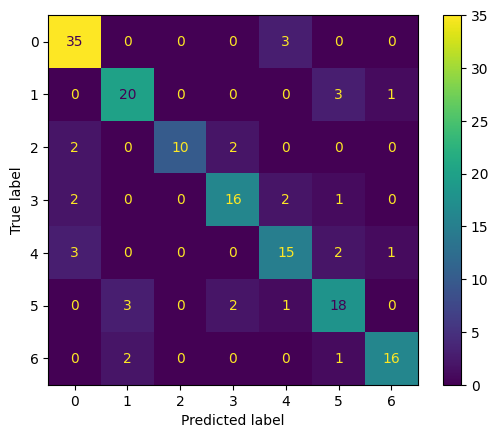


Hard cases for the model:



In [10]:
elm = skelm.ELMClassifier(pairwise_metric='cosine', random_state=0) # also achieved from n_neurons=74 (n_samples / 5 
                                                                    # which is often chosen as default) onwards
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)

Gridsearch is unfortunately not working with pairwise operator for skelm. Comparing different numbers of neurons in the hidden layers ("n_neurons"), shows very different results. Too few or too many neurons lead either to bad predicting or immense overfitting. Overall, leaving "n_neurons" per default brings better results here. "n_neurons=125" gives almost same results (125=n_samples/3).  


Evaluation: f1_score
94.75% for the train data
68.09% for the test data

Evaluation: accuracy_score
94.65% for the train data
70.19% for the test data

Evaluation: precision_score
95.86% for the train data
70.09% for the test data

Evaluation: recall_score
93.98% for the train data
67.36% for the test data

Evaluation: confusion_matrix of test predictions


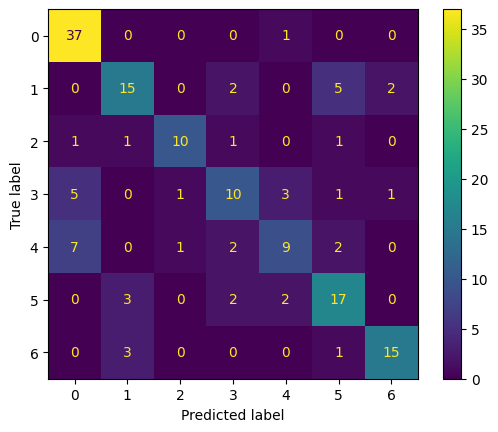


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [40]:
# compare with SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

### After Feature Selection

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.8 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
You have duplicate column names in your data set. Removing duplicate columns now...
    Loaded train data. Shape = (535, 76)
Removing 1 duplicate column(s) of Index(['spectral_centroid_mean'], dtype='object')
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################

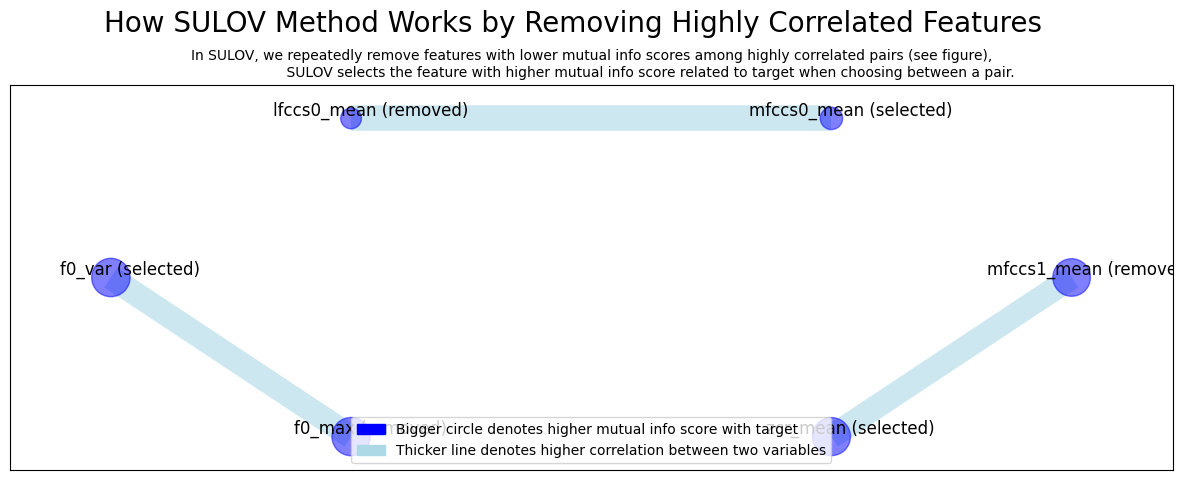

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 71
Finally 71 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 71 
    Taking top 11 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
        using 71 variables...
            selecting 13 features in this iteration
            Time taken for regular XGBoost feature selection = 2 seconds
        using 57 variables...
            selecting 13 features in this iteration
            Time taken for regular XGBoost feature selection = 2 seconds


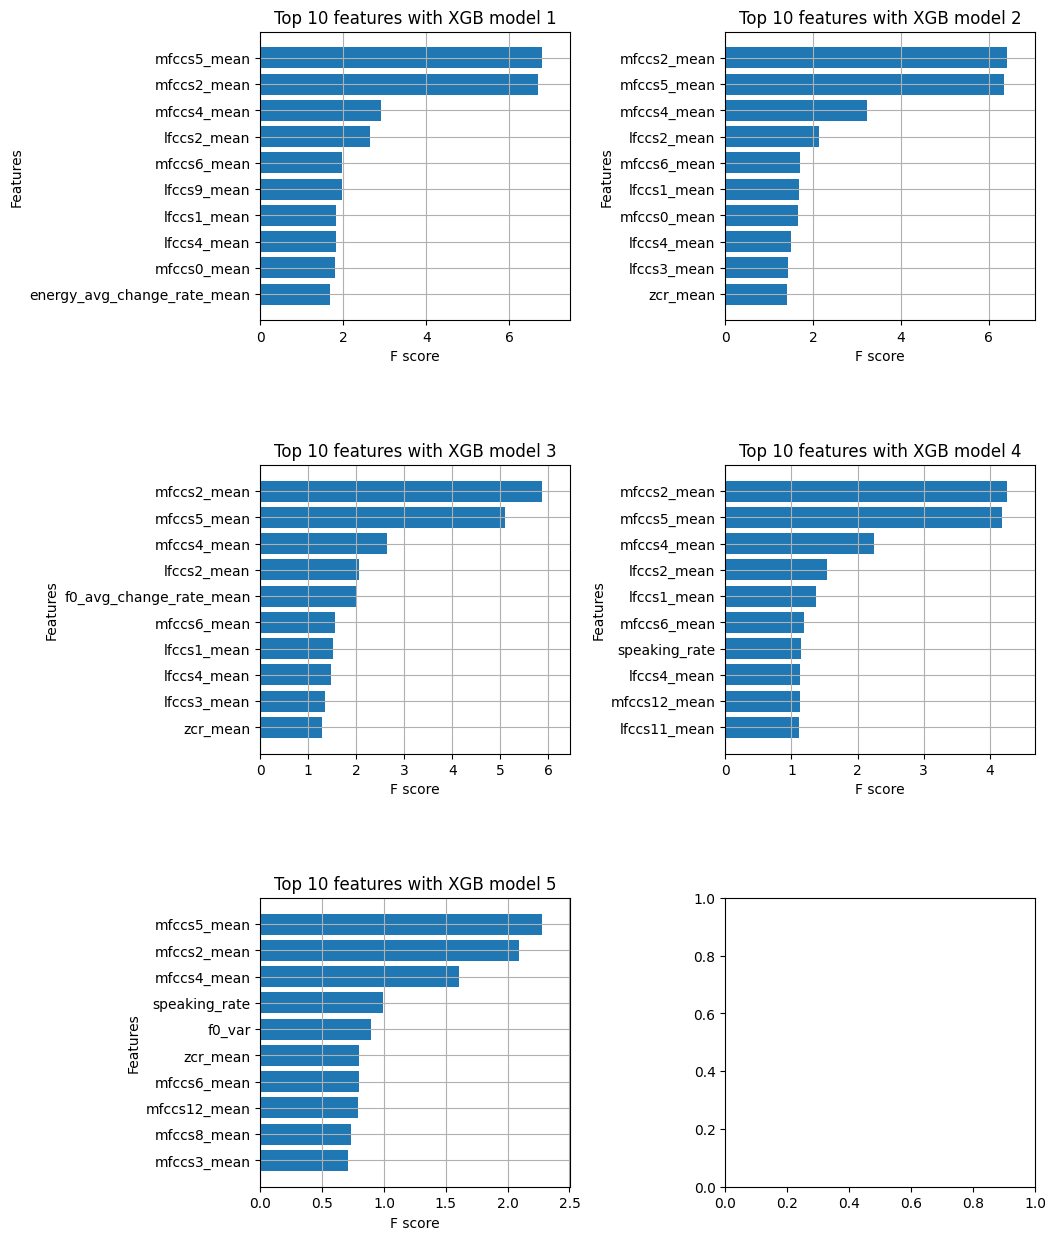

    Completed XGBoost feature selection in 3 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 16 important features:
['mfccs5_mean', 'mfccs2_mean', 'mfccs4_mean', 'lfccs2_mean', 'mfccs6_mean', 'lfccs9_mean', 'lfccs1_mean', 'lfccs4_mean', 'mfccs0_mean', 'energy_avg_change_rate_mean', 'lfccs11_mean', 'f0_var', 'zcr_mean', 'lfccs3_mean', 'mfccs12_mean', 'f0_avg_change_rate_mean']
Total Time taken for featurewiz selection = 13 seconds
Output contains a list of 16 important features and a train dataframe


In [17]:
# automatic feature selection by using featurewiz package
target = 'label'
 
selected_features_paper2, df_paper2_reduced = featurewiz(df_paper2, target, corr_limit=0.8, verbose=2, sep=",", 
                                                         header=0,test_data="", feature_engg="", category_encoders="")

In [41]:
# reload train/test split with selected features
X_train, X_test, y_train, y_test = load_train_test_data(df_paper2_reduced, test_size=0.3)

A snippet of the data:


mfccs5_mean  mfccs2_mean  mfccs4_mean  lfccs2_mean  mfccs6_mean  \
383    -0.883268    -0.217877    -0.921892    -0.795953    -0.448372   
180     2.981771     1.122424     1.454875     1.460728     2.726794   
447     2.016252     1.202789     0.829963     0.028958     1.422007   
409    -0.067690    -1.373864    -0.583640    -0.523046    -0.452259   
268    -1.481929    -1.093820    -1.693030     0.144598     1.162772   

     lfccs9_mean  lfccs1_mean  lfccs4_mean  mfccs0_mean  \
383    -0.892070    -0.917224    -0.088791     0.457343   
180     0.190486     0.531760     1.462702     0.277321   
447     0.526651    -1.599763     0.191534     3.014764   
409    -1.464114     0.469496    -0.863401    -0.234994   
268    -1.221406    -0.456585    -1.296817     0.450180   

     energy_avg_change_rate_mean  lfccs11_mean    f0_var  zcr_mean  \
383                     0.062564     -0.264836  0.681296  1.340242   
180                     0.080092      2.534411 -0.752244 -1.911344   
447                     2.478982      0.474833 -0.570377  0.972242   
409                     0.061564     -0.409716 -0.357108  0.664951   
268                     0.062067     -1.648705  0.865626  0.669922   

     lfccs3_mean  mfccs12_mean  f0_avg_change_rate_mean  
383    -0.424256      0.098980                  -0.3072  
180     0.988820      1.036108                  -0.3072  
447     1.256182     -0.601218                  -0.3072  
409    -0.810094     -0.695221                  -0.3072  
268    -1.369024     -1.282359                  -0.3072

There are 374 entries with 16 columns in the training data.
There are 161 entries with 16 columns in the testing data.



Evaluation: f1_score
91.86% for the train data
52.49% for the test data

Evaluation: accuracy_score
91.98% for the train data
55.28% for the test data

Evaluation: precision_score
92.78% for the train data
54.13% for the test data

Evaluation: recall_score
91.33% for the train data
52.09% for the test data

Evaluation: confusion_matrix of test predictions


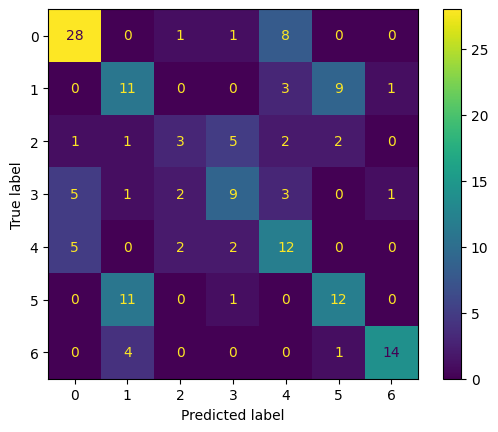


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']
Hard cases of false positives: ['fear(3)', 'happiness(4)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['disgust(2)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)']



In [45]:
# run best model settings with these features again
elm = skelm.ELMClassifier(pairwise_metric='euclidean', random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
81.65% for the train data
54.86% for the test data

Evaluation: accuracy_score
82.89% for the train data
59.63% for the test data

Evaluation: precision_score
84.29% for the train data
65.16% for the test data

Evaluation: recall_score
80.57% for the train data
54.69% for the test data

Evaluation: confusion_matrix of test predictions


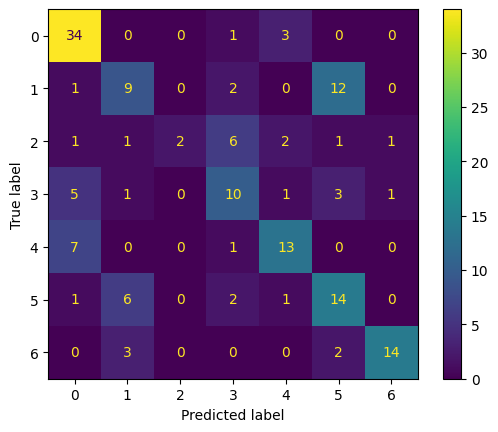


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['disgust(2)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [43]:
# compare with SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

Actually worse after feature selection. Featurewiz probably selected too few features. Let's also try our the ELM model with the most important features selected by featurewiz. 

In [21]:
# load most important 97 data from featurewiz selection
df_most_important97 = pd.read_pickle('../results/df_prep_most_important97.pkl')

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_most_important97, verbose=False, test_size=0.3)


Evaluation: f1_score
94.71% for the train data
73.52% for the test data

Evaluation: accuracy_score
94.39% for the train data
74.53% for the test data

Evaluation: precision_score
95.58% for the train data
75.77% for the test data

Evaluation: recall_score
94.09% for the train data
72.59% for the test data

Evaluation: confusion_matrix of test predictions


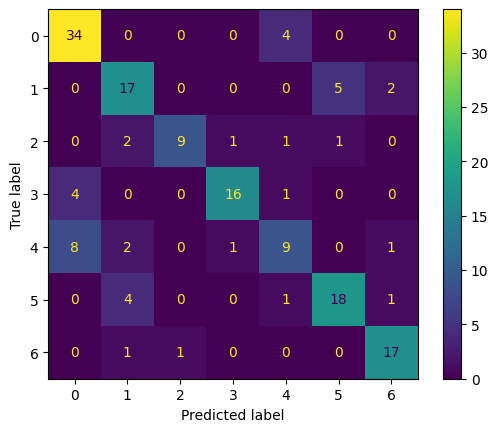


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [26]:
# run best model settings with these features again
elm = skelm.ELMClassifier(pairwise_metric='cosine', random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)

And with all possibile statistics:


Evaluation: f1_score
97.70% for the train data
69.98% for the test data

Evaluation: accuracy_score
97.59% for the train data
70.81% for the test data

Evaluation: precision_score
97.83% for the train data
71.03% for the test data

Evaluation: recall_score
97.68% for the train data
69.92% for the test data

Evaluation: confusion_matrix of test predictions


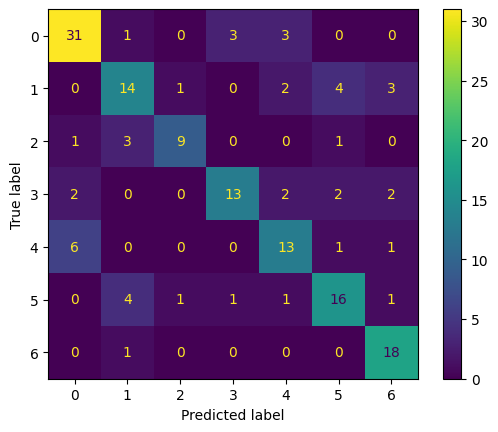


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['boredom(1)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [20]:
# load the data
df_all_stats = pd.read_pickle('../results/df_prep_numerical_only_all_stats.pkl')

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_all_stats, verbose=False, test_size=0.3)

# train and evaluate model
elm = skelm.ELMClassifier(ufunc='sigm', random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)

With PCA:


Evaluation: f1_score
97.32% for the train data
78.26% for the test data

Evaluation: accuracy_score
97.06% for the train data
78.26% for the test data

Evaluation: precision_score
97.80% for the train data
78.79% for the test data

Evaluation: recall_score
96.98% for the train data
78.22% for the test data

Evaluation: confusion_matrix of test predictions


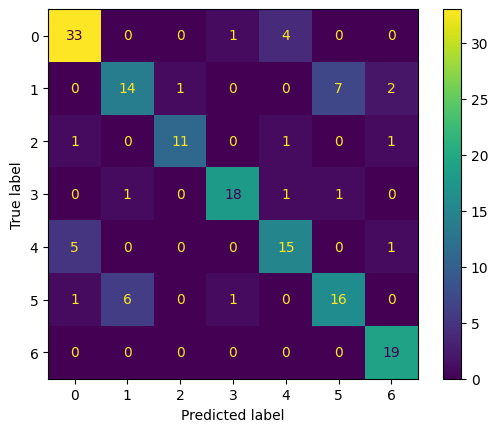


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [36]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(principal_df, verbose=False, test_size=0.3)

# train and evaluate model
elm = skelm.ELMClassifier(pairwise_metric='cosine', random_state=0)
elm.fit(X_train, y_train)
model_eval(elm, X_train, X_test, y_train, y_test, confusion=True)

## SVM with all stats


Evaluation: f1_score
99.32% for the train data
79.06% for the test data

Evaluation: accuracy_score
99.20% for the train data
79.50% for the test data

Evaluation: precision_score
99.53% for the train data
81.70% for the test data

Evaluation: recall_score
99.13% for the train data
77.75% for the test data

Evaluation: confusion_matrix of test predictions


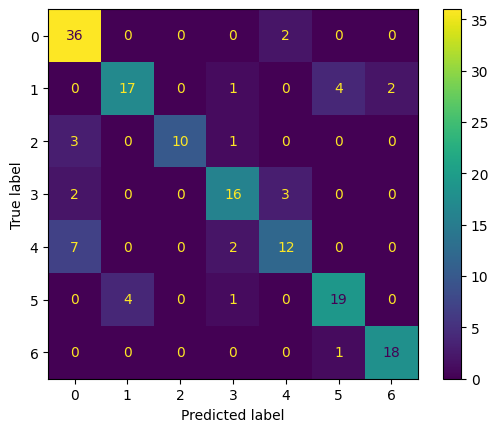


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [16]:
# load the data
df_all_stats = pd.read_pickle('../results/df_prep_numerical_only_all_stats.pkl')

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_all_stats, verbose=False, test_size=0.3)

# train and evaluate svm model
svm_model = SVC()
svm_model.fit(X_train, y_train)
model_eval(svm_model, X_train, X_test, y_train, y_test, confusion=True)

## Feature Importance

RBF kernel. Computing permutation importance.


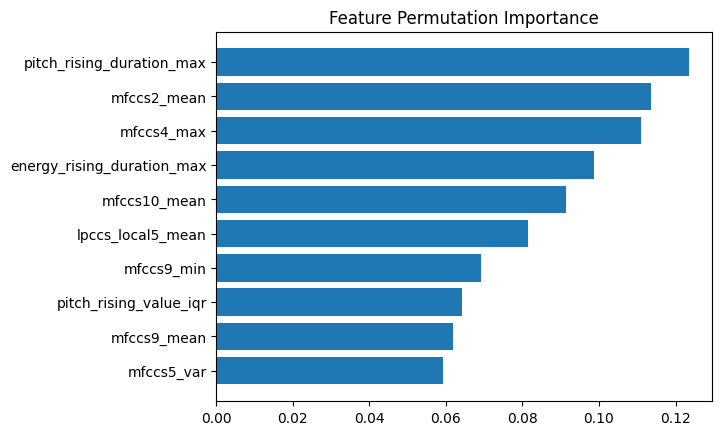

In [55]:
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced, verbose=False)
feature_imp_svm = feature_importance(svm_model, X_test, y_test, top=10)

RBF kernel. Computing permutation importance.


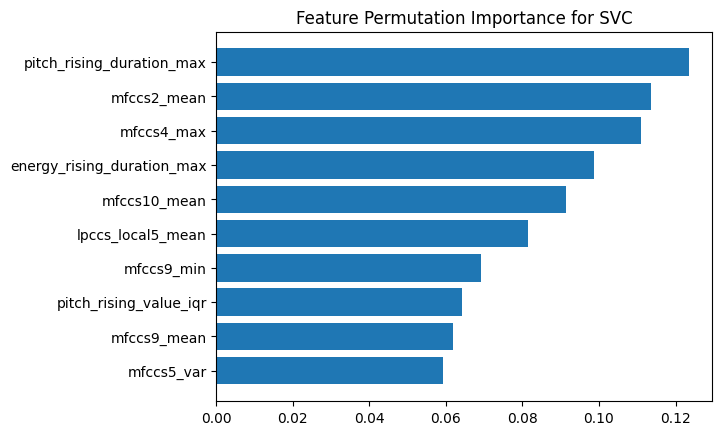

In [9]:
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced, verbose=False)
feature_imp_svm = feature_importance(svm_model, X_test, y_test, top=10)

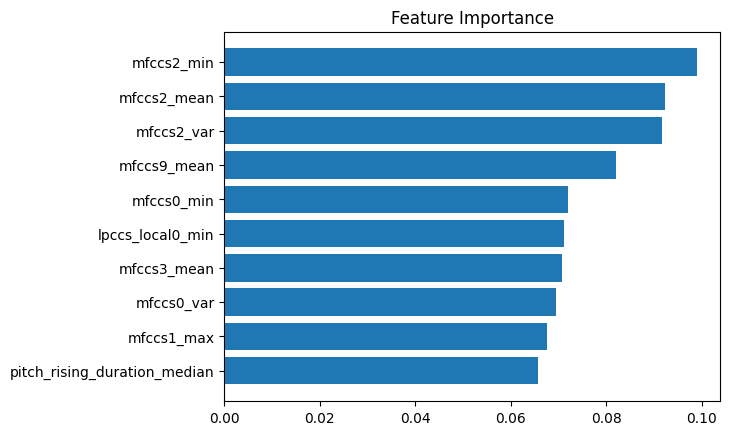

In [12]:
X_train, X_test, y_train, y_test = load_train_test_data(df_3_eplm, verbose=False)
feature_imp_svm = feature_importance(svm_best_model_paper3, X_test, y_test, top=10)

RBF kernel. Computing permutation importance.


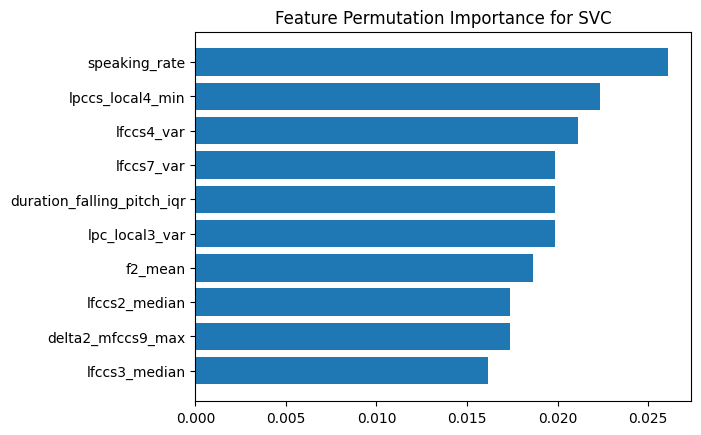

In [23]:
# feature importance of the best svm model
X_train, X_test, y_train, y_test = load_train_test_data(df_reduced_all, verbose=False, test_size=0.3)
feature_imp_svm = feature_importance(svm_model, X_test, y_test, top=10)

In [24]:
feature_imp_svm

('speaking_rate',
 'lpccs_local4_min',
 'lfccs4_var',
 'lfccs7_var',
 'duration_falling_pitch_iqr',
 'lpc_local3_var',
 'f2_mean',
 'lfccs2_median',
 'delta2_mfccs9_max',
 'lfccs3_median')

# Other Models
Besides the features and models from the papers, we also want to investigate other models and find an overall best combination of features and model with highest performance measured in F1 macro.

In [25]:
# load most important 97 data from featurewiz selection
df_most_important97 = pd.read_pickle('../results/df_prep_most_important97.pkl')

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_most_important97, verbose=False, test_size=0.3)

## Decision Tree


Evaluation: f1_score
100.00% for the train data
52.84% for the test data

Evaluation: accuracy_score
100.00% for the train data
53.42% for the test data

Evaluation: precision_score
100.00% for the train data
52.91% for the test data

Evaluation: recall_score
100.00% for the train data
53.59% for the test data

Evaluation: confusion_matrix of test predictions


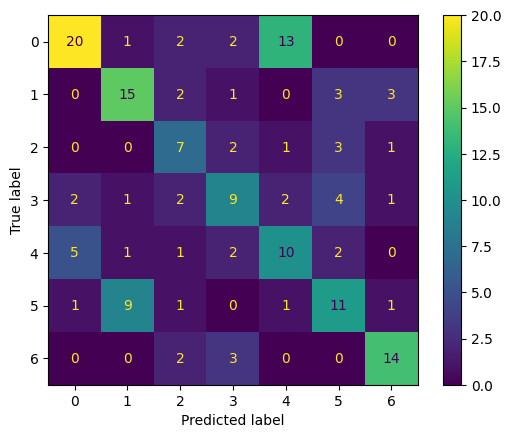


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [69]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)
model_eval(dtc, X_train, X_test, y_train, y_test, confusion=True)

 Number of leaves: 77
 Depth of the tree: 12
 General structure of the generated tree:



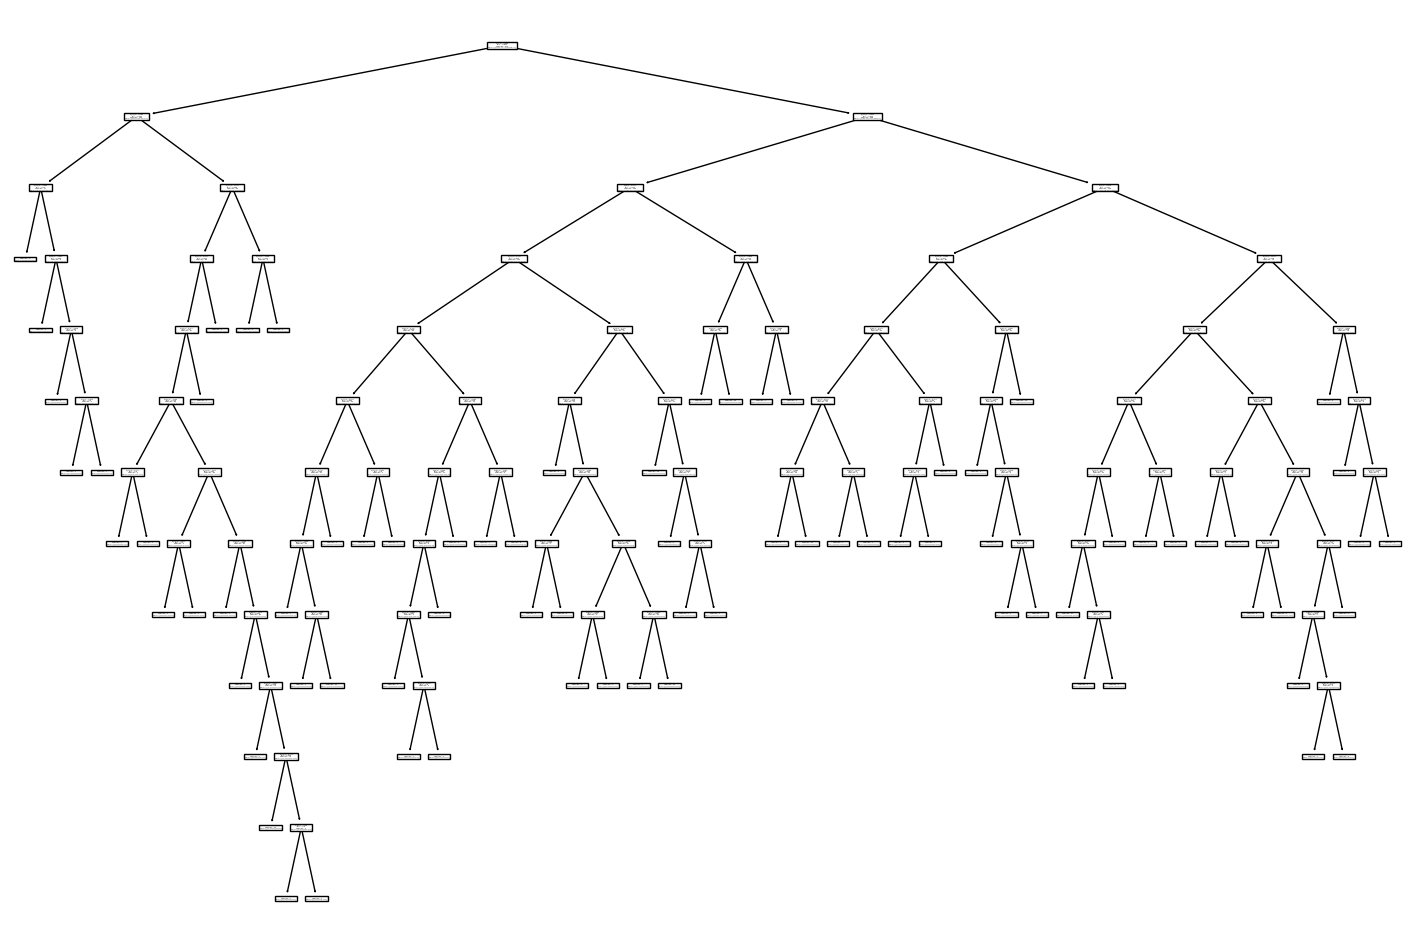

In [70]:
plt.figure(figsize=(18,12))
print(f' Number of leaves: {dtc.get_n_leaves()}\n Depth of the tree: {dtc.get_depth()}\n General structure of the generated tree:\n')
x = plot_tree(dtc)

As expected, the DecisionTreeClassifier is extremely overfitting. Let's see if a slight change of hyperparameters can improve this.

In [71]:
# define grid
decision_tree_grid = {'criterion' : ['gini', 'entropy'], 
                      'max_depth' : [5, 10, 20, 30]
                     }

In [72]:
run_gridsearchCV(dtc, decision_tree_grid, X_train, y_train, verbose=0)


Best hyperparameters : {'criterion': 'gini', 'max_depth': 5}
Best cross-validated f1_macro : 0.5173792494315348



Evaluation: f1_score
77.22% for the train data
55.53% for the test data

Evaluation: accuracy_score
78.61% for the train data
58.39% for the test data

Evaluation: precision_score
82.41% for the train data
57.82% for the test data

Evaluation: recall_score
75.62% for the train data
55.23% for the test data

Evaluation: confusion_matrix of test predictions


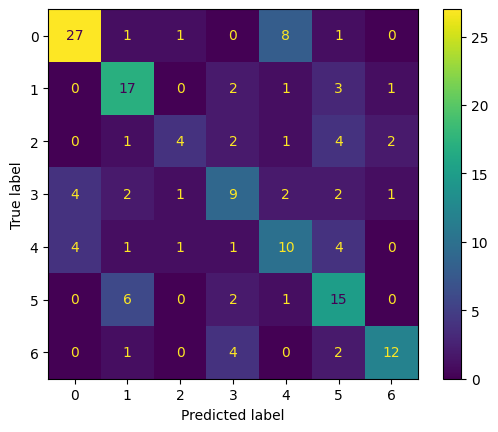


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']

Label: sadness(6)
Hard cases of false negatives: ['fear(3)']



In [73]:
# reload the best model & evaluate
dtc_best_model = load_model('DecisionTreeClassifier', 'f1_macro')
model_eval(dtc_best_model, X_train, X_test, y_train, y_test, confusion=True)

 Number of leaves: 25
 Depth of the tree: 5
 General structure of the generated tree:



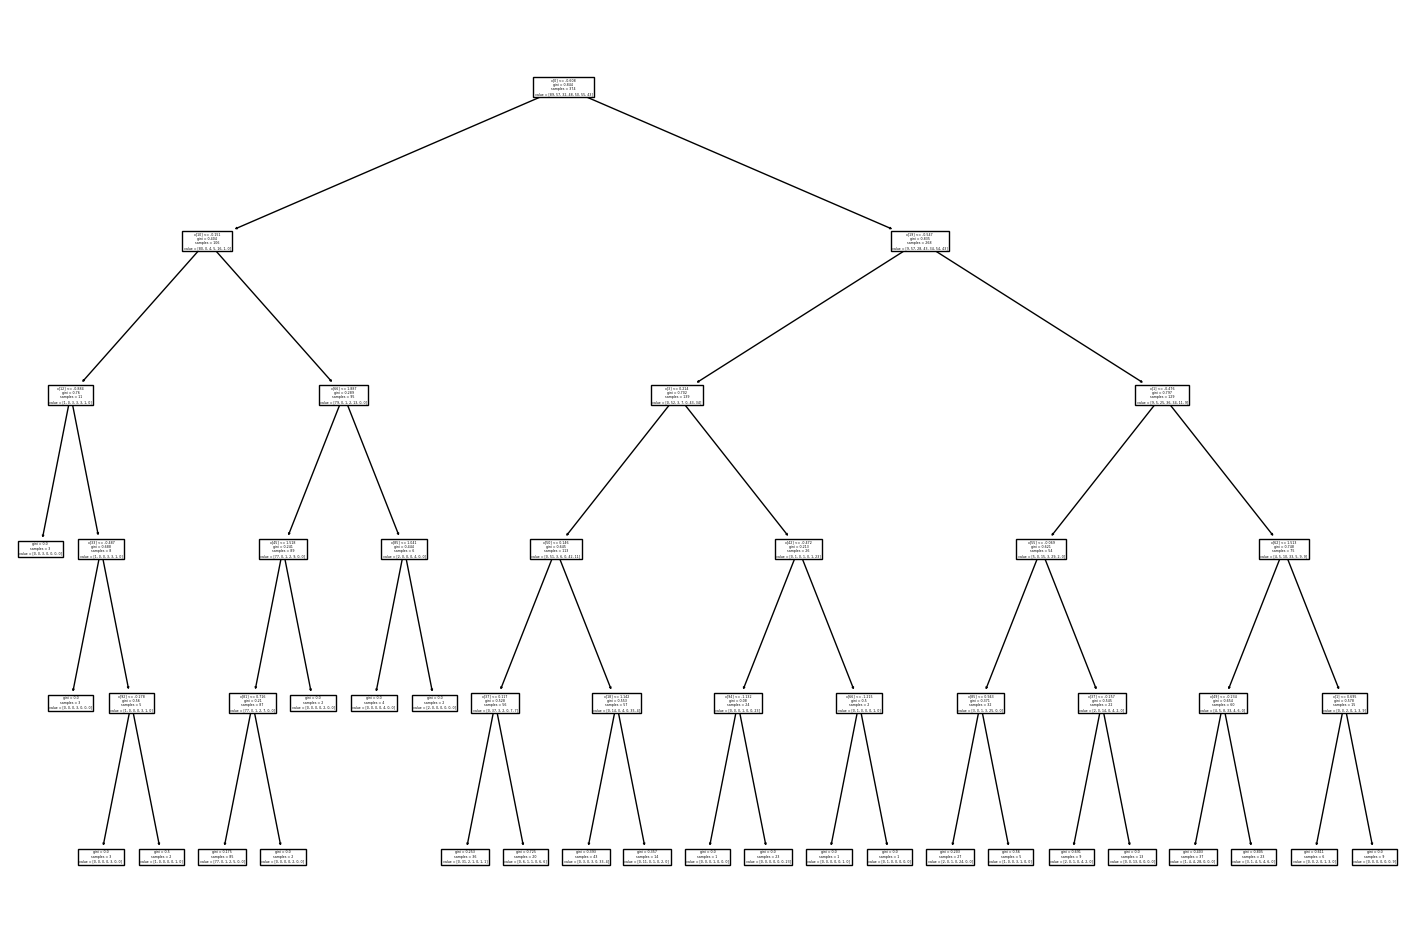

In [74]:
plt.figure(figsize=(18,12))
print(f' Number of leaves: {dtc_best_model.get_n_leaves()}\n Depth of the tree: {dtc_best_model.get_depth()}\n General structure of the generated tree:\n')
x = plot_tree(dtc_best_model)

Still bad generalization!

## Random Forest


Evaluation: f1_score
100.00% for the train data
71.08% for the test data

Evaluation: accuracy_score
100.00% for the train data
72.67% for the test data

Evaluation: precision_score
100.00% for the train data
74.45% for the test data

Evaluation: recall_score
100.00% for the train data
69.94% for the test data

Evaluation: confusion_matrix of test predictions


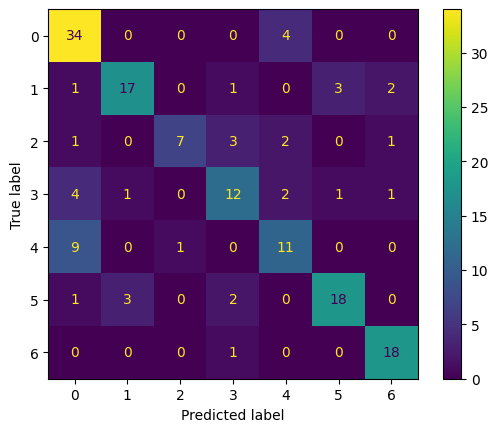


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']



In [75]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
model_eval(rfc, X_train, X_test, y_train, y_test, confusion=True)

In [76]:
# define grid
random_forest_grid = {'n_estimators': [5, 10, 100, 200],
                      'max_depth' : [5, 10, 20, 30],
                      'bootstrap': [True, False],
                      'warm_start': [True, False]
                     }

In [77]:
run_gridsearchCV(rfc, random_forest_grid, X_train, y_train, verbose=0)


Best hyperparameters : {'bootstrap': False, 'max_depth': 20, 'n_estimators': 200, 'warm_start': True}
Best cross-validated f1_macro : 0.7735604514033432



Evaluation: f1_score
100.00% for the train data
79.14% for the test data

Evaluation: accuracy_score
100.00% for the train data
79.50% for the test data

Evaluation: precision_score
100.00% for the train data
81.79% for the test data

Evaluation: recall_score
100.00% for the train data
78.02% for the test data

Evaluation: confusion_matrix of test predictions


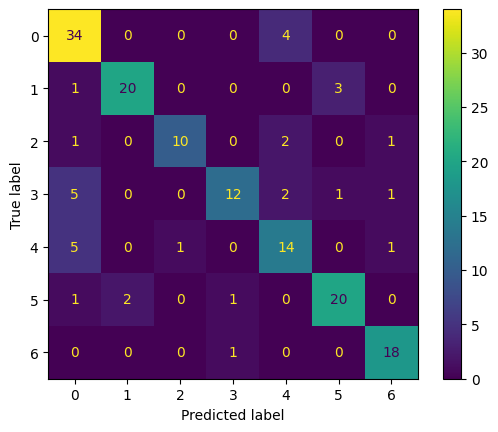


Hard cases for the model:

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [9]:
# reload the best model & evaluate
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro')
model_eval(rfc_best_model, X_train, X_test, y_train, y_test, confusion=True)

## KNN Classifier


Evaluation: f1_score
81.15% for the train data
64.47% for the test data

Evaluation: accuracy_score
81.55% for the train data
65.84% for the test data

Evaluation: precision_score
84.00% for the train data
66.36% for the test data

Evaluation: recall_score
80.15% for the train data
64.40% for the test data

Evaluation: confusion_matrix of test predictions


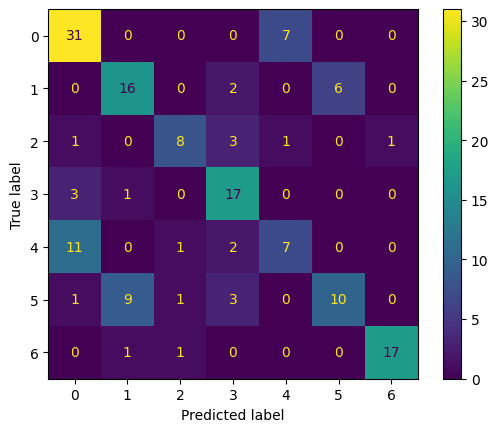


Hard cases for the model:

Label: anger(0)
Hard cases of false positives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [122]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
model_eval(knn, X_train, X_test, y_train, y_test, confusion=True)

In [85]:
# define grid
knn_grid = {'n_neighbors': [3, 4, 5, 6, 7, 8],
           'weights': ['uniform', 'distance'],
           }

In [86]:
run_gridsearchCV(knn, knn_grid, X_train, y_train, verbose=0)


Best hyperparameters : {'n_neighbors': 7, 'weights': 'distance'}
Best cross-validated f1_macro : 0.6741918202773153



Evaluation: f1_score
100.00% for the train data
63.71% for the test data

Evaluation: accuracy_score
100.00% for the train data
64.60% for the test data

Evaluation: precision_score
100.00% for the train data
66.14% for the test data

Evaluation: recall_score
100.00% for the train data
63.60% for the test data

Evaluation: confusion_matrix of test predictions


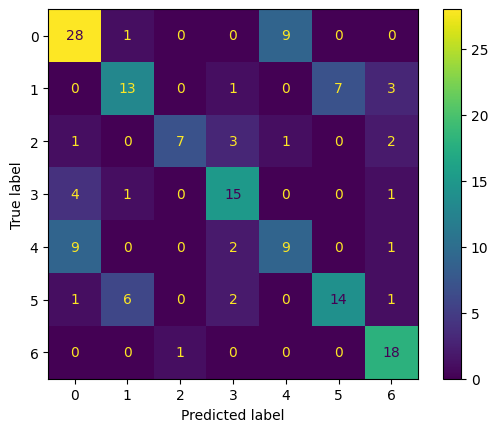


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']
Hard cases of false positives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['fear(3)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [87]:
# reload the best model & evaluate
knn_best_model = load_model('KNeighborsClassifier', 'f1_macro')
model_eval(knn_best_model, X_train, X_test, y_train, y_test, confusion=True)

## Naive Bayes

In [105]:
# first check if data follows a normal distribution
from scipy.stats import shapiro

looks_gaussian = []
doesntlook_gaussian = []

for feature in X_train.columns:
    stat, p = shapiro(X_train[feature])
    #print('Feature {}: Statistics = {}, p = {}'.format(feature, stat, p))
    alpha = 0.05
    if p > alpha:
        looks_gaussian.append(feature)
    else:
        doesntlook_gaussian.append(feature)

print('Feature that look Gaussian:\n{}\n'.format(looks_gaussian))
print('Feature that do not look Gaussian:\n{}'.format(doesntlook_gaussian))

Feature that look Gaussian:
['zcr_max', 'lpc_local1_mean', 'f2_mean', 'mfccs4_max', 'lpc_local4_median', 'lfccs6_mean', 'speaking_rate', 'amplitude_avg_change_rate_min', 'f2_avg_change_rate_max', 'lpc_global_median', 'threshold_entropy_mean', 'lfccs4_median', 'mfccs5_max', 'lfccs3_median', 'lfccs11_mean', 'lfccs8_mean', 'lfccs10_median']

Feature that do not look Gaussian:
['rms_min', 'mfccs5_mean', 'duration_rising_pitch_max', 'lpccs_local4_min', 'lfccs9_max', 'min', 'energy_median', 'lfccs0_median', 'lpccs_global_median', 'lpc_global_mean', 'value_falling_energy_max', 'mfccs11_mean', 'f1_min', 'lpc_local3_var', 'lpccs_local0_var', 'f0_avg_change_rate_median', 'lfccs9_median', 'delta_mfccs0_min', 'value_falling_pitch_iqr', 'f1_avg_change_rate_var', 'threshold_entropy_var', 'mfccs3_max', 'lfccs7_var', 'lfccs9_var', 'delta_mfccs5_median', 'energy_var', 'delta2_mfccs3_min', 'lpccs_local5_mean', 'shannon_entropy_mean', 'delta2_mfccs5_mean', 'delta_mfccs4_median', 'f3_mean', 'mfccs5_var', 


Evaluation: f1_score
83.53% for the train data
70.95% for the test data

Evaluation: accuracy_score
83.69% for the train data
70.81% for the test data

Evaluation: precision_score
83.02% for the train data
72.97% for the test data

Evaluation: recall_score
84.61% for the train data
70.72% for the test data

Evaluation: confusion_matrix of test predictions


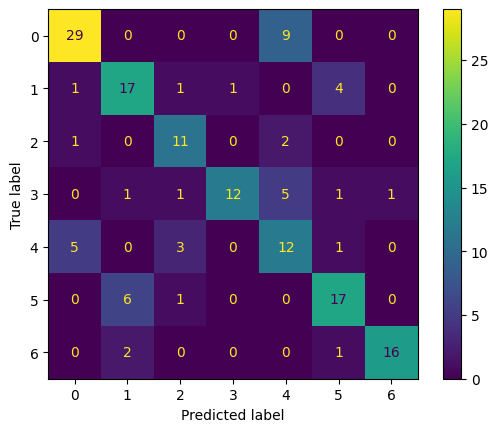


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [123]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
model_eval(gnb, X_train, X_test, y_train, y_test, confusion=True)


Evaluation: f1_score
75.41% for the train data
74.31% for the test data

Evaluation: accuracy_score
76.20% for the train data
73.29% for the test data

Evaluation: precision_score
75.53% for the train data
75.46% for the test data

Evaluation: recall_score
75.53% for the train data
74.35% for the test data

Evaluation: confusion_matrix of test predictions


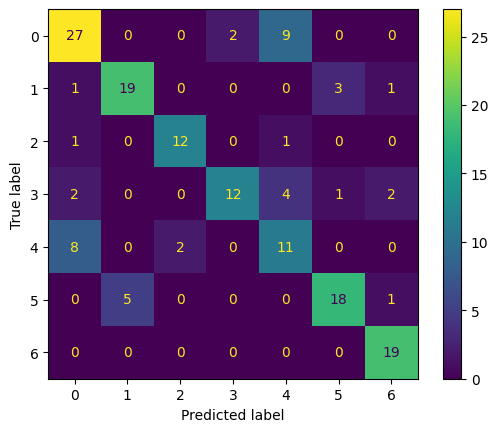


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']
Hard cases of false positives: ['happiness(4)']

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']



In [124]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
model_eval(bnb, X_train, X_test, y_train, y_test, confusion=True)

## XGBoost Classifier


Evaluation: f1_score
100.00% for the train data
73.35% for the test data

Evaluation: accuracy_score
100.00% for the train data
73.29% for the test data

Evaluation: precision_score
100.00% for the train data
73.09% for the test data

Evaluation: recall_score
100.00% for the train data
74.39% for the test data

Evaluation: confusion_matrix of test predictions


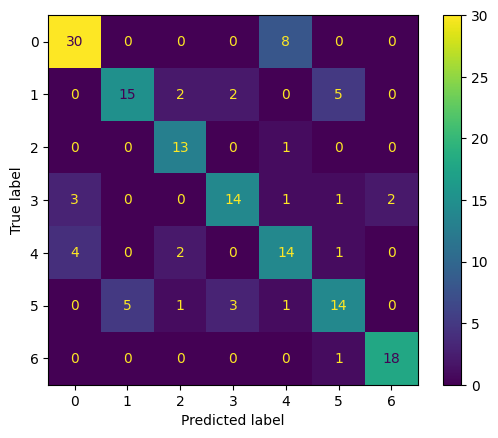


Hard cases for the model:

Label: anger(0)
Hard cases of false negatives: ['happiness(4)']

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [4]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)
model_eval(xgb, X_train, X_test, y_train, y_test, confusion=True)

In [7]:
# define grid
xgb_grid = {'n_estimators': [5, 10, 100, 200, 250, 300],
            'max_depth' : [2, 5, 10, 20, 30],
            'learning_rate': [0.001, 0.01, 0.1, 0.5]
           }

In [138]:
run_gridsearchCV(xgb, xgb_grid, X_train, y_train, verbose=0)


Best hyperparameters : {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 250}
Best cross-validated f1_macro : 0.7581574518523653



Evaluation: f1_score
100.00% for the train data
80.31% for the test data

Evaluation: accuracy_score
100.00% for the train data
80.12% for the test data

Evaluation: precision_score
100.00% for the train data
80.96% for the test data

Evaluation: recall_score
100.00% for the train data
80.03% for the test data

Evaluation: confusion_matrix of test predictions


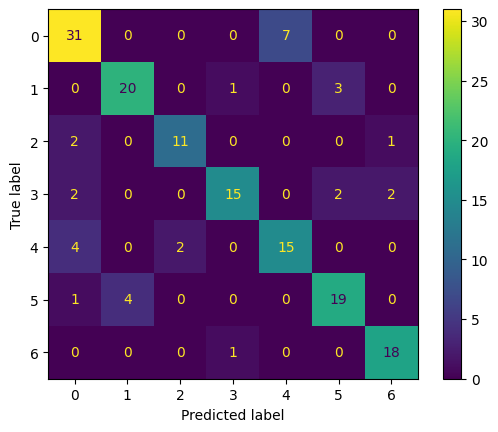


Hard cases for the model:

Label: happiness(4)
Hard cases of false positives: ['anger(0)']



In [139]:
# reload the best model & evaluate
xgb_best_model = load_model('XGBClassifier', 'f1_macro')
model_eval(xgb_best_model, X_train, X_test, y_train, y_test, confusion=True)

From all of these traditional models, Random Forest and XGB Classifier show best performance. Hence, let's also run the models with all numerical features we created and also try out it's performance with PCA.
### a) With all numerical features

In [5]:
# load the data iwth all numerical features
df_all_stats = pd.read_pickle('../results/df_prep_numerical_only_all_stats.pkl')

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_all_stats, verbose=False, test_size=0.3)

#### Random Forest 

In [118]:
run_gridsearchCV(rfc, random_forest_grid, X_train, y_train, verbose=0, name_spec='with_all_stats')


Best hyperparameters : {'bootstrap': False, 'max_depth': 10, 'n_estimators': 200, 'warm_start': True}
Best cross-validated f1_macro : 0.7387847399226148



Evaluation: f1_score
100.00% for the train data
77.66% for the test data

Evaluation: accuracy_score
100.00% for the train data
78.88% for the test data

Evaluation: precision_score
100.00% for the train data
80.03% for the test data

Evaluation: recall_score
100.00% for the train data
76.81% for the test data

Evaluation: confusion_matrix of test predictions


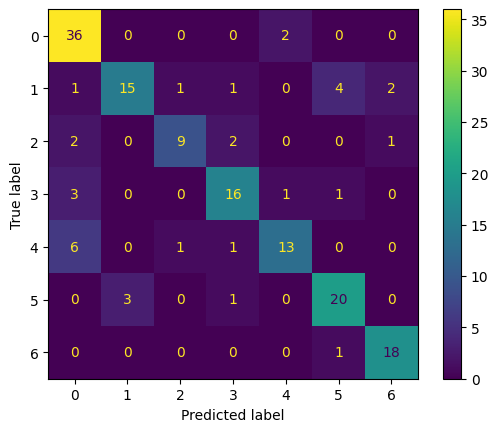


Hard cases for the model:

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']



In [119]:
# reload the best model & evaluate
rfc_best_model_all_stats = load_model('RandomForestClassifier', 'f1_macro', name_spec='with_all_stats')
model_eval(rfc_best_model_all_stats, X_train, X_test, y_train, y_test, confusion=True)

#### XGB Classifier

In [8]:
run_gridsearchCV(xgb, xgb_grid, X_train, y_train, verbose=0, name_spec='with_all_stats')


Best hyperparameters : {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 100}
Best cross-validated f1_macro : 0.755863745042254



Evaluation: f1_score
100.00% for the train data
80.49% for the test data

Evaluation: accuracy_score
100.00% for the train data
80.75% for the test data

Evaluation: precision_score
100.00% for the train data
81.72% for the test data

Evaluation: recall_score
100.00% for the train data
79.89% for the test data

Evaluation: confusion_matrix of test predictions


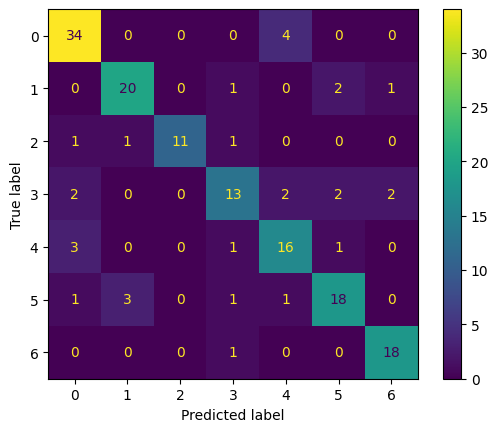


Hard cases for the model:



In [9]:
# reload the best model & evaluate
xgb_best_model_all_stats = load_model('XGBClassifier', 'f1_macro', name_spec='with_all_stats')
model_eval(xgb_best_model_all_stats, X_train, X_test, y_train, y_test, confusion=True)

### b) with PCA

In [11]:
pca = PCA(0.9)
principalComponents = pca.fit_transform(df_all_stats.drop('label', axis=1))

principal_df = pd.DataFrame(data = principalComponents)
principal_df = pd.concat([principal_df, df_all_stats[['label']]], axis = 1)

print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

103
[0.1371097  0.1225378  0.04878109 0.04306813 0.03503977 0.03143388
 0.02841167 0.02122009 0.01921022 0.01644826 0.01569456 0.01476704
 0.01442153 0.01311755 0.01305086 0.01188505 0.01135937 0.01061576
 0.01011364 0.00922488 0.00884234 0.00823372 0.00770304 0.00751619
 0.0071806  0.00701369 0.00693512 0.00659679 0.00637725 0.00610694
 0.00588616 0.00584404 0.00550799 0.00536687 0.00504853 0.00482218
 0.00472164 0.00452798 0.00438488 0.00430476 0.00414801 0.00408645
 0.0040593  0.00381127 0.00378764 0.00361238 0.00355297 0.00350895
 0.00345933 0.00336829 0.00329617 0.00314747 0.00311828 0.00304889
 0.0029914  0.00296533 0.00284535 0.0028187  0.00276443 0.0027123
 0.00267024 0.00261958 0.00260387 0.00251982 0.00244606 0.00243382
 0.0023608  0.00232406 0.00227299 0.00225475 0.00222684 0.00218453
 0.0021589  0.00212355 0.00208363 0.00205167 0.00204371 0.00196448
 0.00195309 0.00193649 0.00193473 0.00188694 0.00186865 0.00183865
 0.00183572 0.00179142 0.00176027 0.00173093 0.00172303 0.0

In [12]:
# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(principal_df, verbose=False, test_size=0.3)

#### Random Forest

In [127]:
run_gridsearchCV(rfc, random_forest_grid, X_train, y_train, verbose=0, name_spec='with_pca')


Best hyperparameters : {'bootstrap': False, 'max_depth': 20, 'n_estimators': 200, 'warm_start': True}
Best cross-validated f1_macro : 0.6476876795780924



Evaluation: f1_score
100.00% for the train data
71.50% for the test data

Evaluation: accuracy_score
100.00% for the train data
72.05% for the test data

Evaluation: precision_score
100.00% for the train data
78.06% for the test data

Evaluation: recall_score
100.00% for the train data
69.88% for the test data

Evaluation: confusion_matrix of test predictions


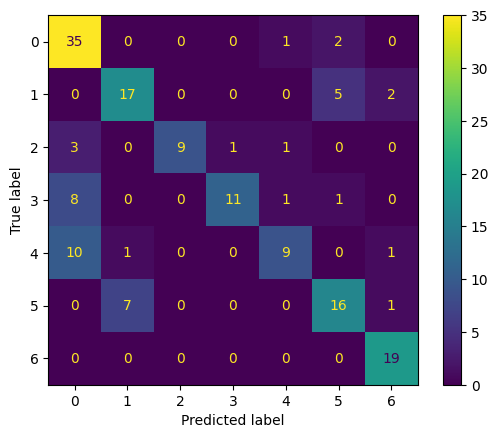


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [129]:
# reload the best model & evaluate
rfc_best_model_pca = load_model('RandomForestClassifier', 'f1_macro', name_spec='with_pca')
model_eval(rfc_best_model_pca, X_train, X_test, y_train, y_test, confusion=True)

#### XGB Classifier

In [13]:
run_gridsearchCV(xgb, xgb_grid, X_train, y_train, verbose=0, name_spec='with_pca')


Best hyperparameters : {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 200}
Best cross-validated f1_macro : 0.6957647659387592



Evaluation: f1_score
100.00% for the train data
70.55% for the test data

Evaluation: accuracy_score
100.00% for the train data
70.81% for the test data

Evaluation: precision_score
100.00% for the train data
73.64% for the test data

Evaluation: recall_score
100.00% for the train data
69.18% for the test data

Evaluation: confusion_matrix of test predictions


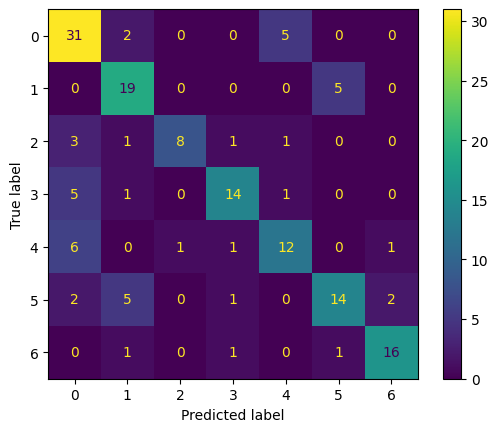


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false negatives: ['boredom(1)']
Hard cases of false positives: ['boredom(1)']



In [14]:
# reload the best model & evaluate
xgb_best_model_pca = load_model('XGBClassifier', 'f1_macro', name_spec='with_pca')
model_eval(xgb_best_model_pca, X_train, X_test, y_train, y_test, confusion=True)

## Feature Importance for other models
Models perform best with featurewiz 97 data set. Let's look at the feature importances within the different models on that data set.

In [26]:
# load most important 97 data from featurewiz selection
df_most_important97 = pd.read_pickle('../results/df_prep_most_important97.pkl')

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_most_important97, verbose=False, test_size=0.3)

RBF kernel. Computing permutation importance.


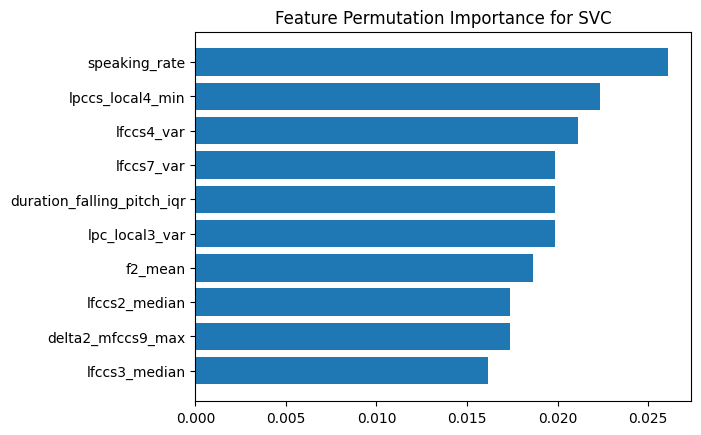

In [27]:
svm_best_model = load_model('SVC', 'f1_macro', name_spec='most_important97') # load model
feature_imp_svm = feature_importance(svm_best_model, X_test, y_test, top=10)

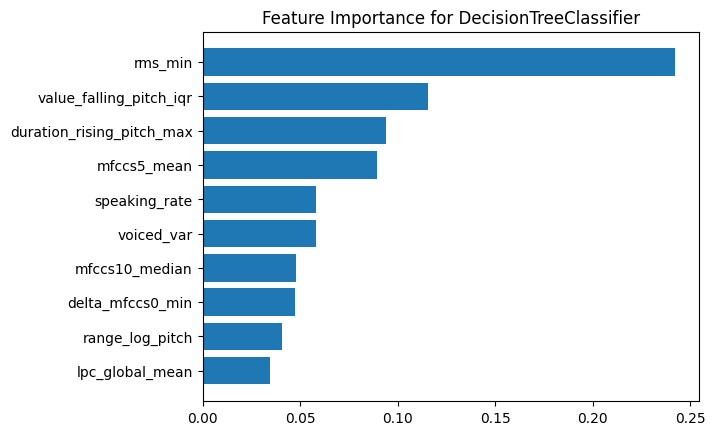

In [29]:
dtc_best_model = load_model('DecisionTreeClassifier', 'f1_macro') # load model
feature_imp_dtc = feature_importance(dtc_best_model, X_test, y_test, top=10)

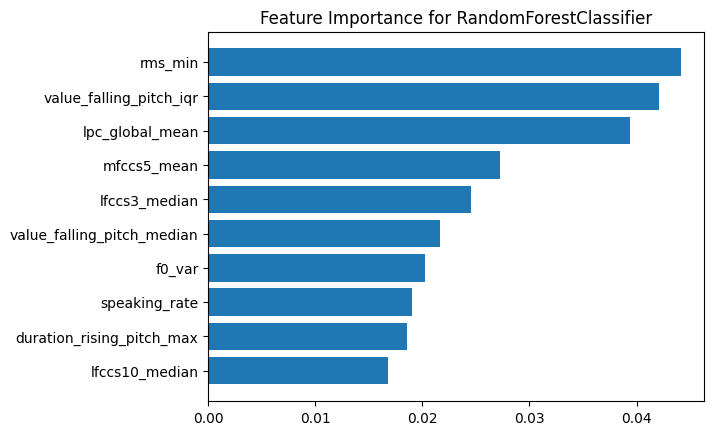

In [31]:
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro') # load model
feature_imp_rfc = feature_importance(rfc_best_model, X_test, y_test, top=10)

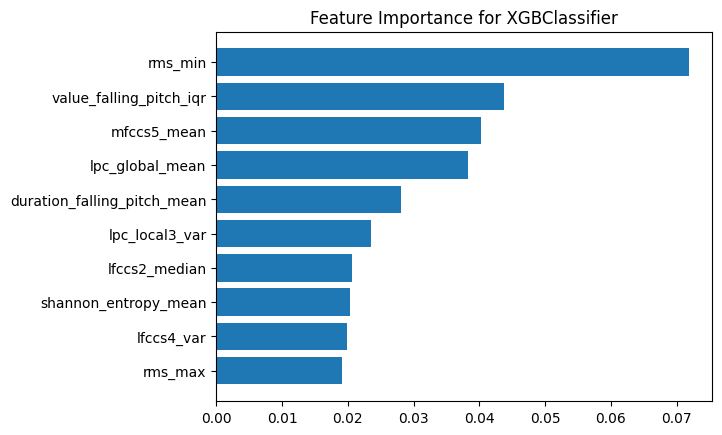

In [34]:
xgb_best_model = load_model('XGBClassifier', 'f1_macro') # load model
feature_imp_xgb = feature_importance(xgb_best_model, X_test, y_test, top=10)

# HMM
with lists, one-dimensional numpy arrays only (numerical values, multi-dimensional arrays excluded)

In [45]:
def get_max_list_length(df, column_name):
    max_length = max(len(lst) for lst in df[column_name])
    return max_length

In [46]:
# load data (does not have to have numerical features only for HMM)
df_ext = pd.read_pickle('../results/extracted_features_modified.pkl')
df = pd.read_pickle('../results/df_prep_numerical_only.pkl')

# filter out numerical features
list_array_cols = df_ext.apply(lambda x: isinstance(x[0], (list, np.ndarray)))
features = df_ext[df_ext.columns[list_array_cols]]
features.drop(columns=['voiced', 'pitch_time'], inplace=True)

# filter out multidimensional arrays
features_filtered = features.loc[:, [col for col in features.columns if np.ndim(features[col][1]) <= 1]] 

# convert all lists to arrays
for col in features_filtered:
    features_filtered[col] = features_filtered[col].apply(lambda x: np.array(x))
    
# get the maximum length of a given feature and pad them to the same length within one feature
for col in features_filtered.columns:
    max_length = get_max_list_length(features_filtered, col)
    features_filtered[col] = features_filtered[col].apply(lambda x: np.concatenate((x,np.zeros(max_length - len(x)))))

# concatenate all columns row-wise
X = features_filtered.apply(lambda row: np.concatenate(row), axis=1)

# concatenate features with label
df_arrays_filtered = pd.concat([X, df[['label']]], axis = 1).rename(columns={0:'features'})

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_arrays_filtered, test_size=0.3)

A snippet of the data:


features
383  [0.015625, 0.02294921875, 0.025390625, 0.03076...
180  [0.02294921875, 0.025390625, 0.05322265625, 0....
447  [0.0703125, 0.09423828125, 0.10009765625, 0.08...
409  [0.037109375, 0.0615234375, 0.10791015625, 0.0...
268  [0.0546875, 0.07080078125, 0.1728515625, 0.309...

There are 374 entries with 1 columns in the training data.
There are 161 entries with 1 columns in the testing data.


In [25]:
# define a HMM model
hmm_model = hmm.GaussianHMM(n_components=3, random_state=0, n_iter=1000)

In [26]:
def train_hmm(hmm_model, X_train, y_train):
    # Create and train HMM models
    n_classes = len(np.unique(y_train))
    hmm_models = []

    for class_label in range(n_classes):
        # Prepare class-specific training data
        X_class = X_train[y_train == class_label]['features']

        # concatenate all rows into a single array
        X_concat = np.concatenate(X_class.values).reshape(-1, 1)

        # define a list of lengths for slicing
        row_length = len(X_class.iloc[0])
        lengths = row_length * np.ones(X_class.shape[0], dtype='int32')

        # train the HMM model
        hmm_model.fit(X_concat, lengths)

        # Add trained model to the list
        hmm_models.append(hmm_model)
    
    return hmm_models

In [27]:
train_hmm(hmm_model, X_train, y_train)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


[GaussianHMM(n_components=3, n_iter=1000, random_state=0),
 GaussianHMM(n_components=3, n_iter=1000, random_state=0),
 GaussianHMM(n_components=3, n_iter=1000, random_state=0),
 GaussianHMM(n_components=3, n_iter=1000, random_state=0),
 GaussianHMM(n_components=3, n_iter=1000, random_state=0),
 GaussianHMM(n_components=3, n_iter=1000, random_state=0),
 GaussianHMM(n_components=3, n_iter=1000, random_state=0)]

In [11]:
def hmm_prediction(X, hmm_models):
    # Predict the class for a new sample
    y_pred = []

    for sample in X['features']:
        sample_pred = []
        for model in hmm_models:
            # Compute the log-likelihood of the sample under each model
            log_likelihood = model.score(sample.reshape(-1, 1))

            # Append the log-likelihood to the list of predictions
            sample_pred.append(log_likelihood)

        # Determine the predicted class based on the highest log-likelihood
        predicted_class = np.argmax(sample_pred)
        y_pred.append(predicted_class)
    return y_pred

In [28]:
model_eval(hmm_model, X_train, X_test, y_train, y_test, prediction_train_test=(hmm_prediction(X_train, hmm_models), 
                                                                            hmm_prediction(X_test, hmm_models)))


Evaluation: f1_score
6.08% for the train data
3.73% for the test data

Evaluation: accuracy_score
15.51% for the train data
14.91% for the test data

Evaluation: precision_score
12.84% for the train data
2.14% for the test data

Evaluation: recall_score
15.62% for the train data
14.29% for the test data


In [350]:
hmm_prediction(X_test, models)

[5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5]

In [339]:
y_test

55     3
403    2
449    5
498    6
354    2
      ..
341    2
356    6
204    4
484    0
82     5
Name: label, Length: 161, dtype: int32

In [47]:
# define a HMM model
hmm_model = hmm.GMMHMM(n_mix=3, n_components=3, random_state=0, n_iter=1000)

In [48]:
train_hmm(hmm_model, X_train, y_train)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains '

[GMMHMM(covars_prior=array([[[-1.5],
         [-1.5],
         [-1.5]],
 
        [[-1.5],
         [-1.5],
         [-1.5]],
 
        [[-1.5],
         [-1.5],
         [-1.5]]]),
        covars_weight=array([[[0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.]]]),
        means_prior=array([[[0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.]]]),
        means_weight=array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
        n_components=3, n_iter=1000, n_mix=3, random_state=0,
        weights_prior=array([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])),
 GMMHMM(covars_prior=array([[[-1.5],
         [-1.5],
         [-1.5]],
 
        [[-1.5],
         [-1.5],
         [-1.5]],
 
        [[-1.5],
         [-1.5],
         [-1.5]]]),
        covars_weight=array([[[0.],
         [0.],
         [0.]],
 

In [49]:
model_eval(hmm_model, X_train, X_test, y_train, y_test, prediction_train_test=(hmm_prediction(X_train, hmm_models), 
                                                                            hmm_prediction(X_test, hmm_models)))


Evaluation: f1_score
6.08% for the train data
3.73% for the test data

Evaluation: accuracy_score
15.51% for the train data
14.91% for the test data

Evaluation: precision_score
12.84% for the train data
2.14% for the test data

Evaluation: recall_score
15.62% for the train data
14.29% for the test data


## HMM with numerical features only

In [31]:
# load most important 97 data from featurewiz selection
df_most_important97 = pd.read_pickle('../results/df_prep_most_important97.pkl')

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_most_important97, verbose=False, test_size=0.3)

In [32]:
hmm_model = hmm.GaussianHMM(n_components=7, n_iter=1000, random_state=0)
hmm_model.fit(X_train)

GaussianHMM(n_components=7, n_iter=1000, random_state=0)

In [33]:
model_eval(hmm_model, X_train, X_test, y_train, y_test)


Evaluation: f1_score
15.86% for the train data
12.25% for the test data

Evaluation: accuracy_score
15.51% for the train data
12.42% for the test data

Evaluation: precision_score
17.56% for the train data
13.30% for the test data

Evaluation: recall_score
15.80% for the train data
13.18% for the test data


HMM is not suitable for this case